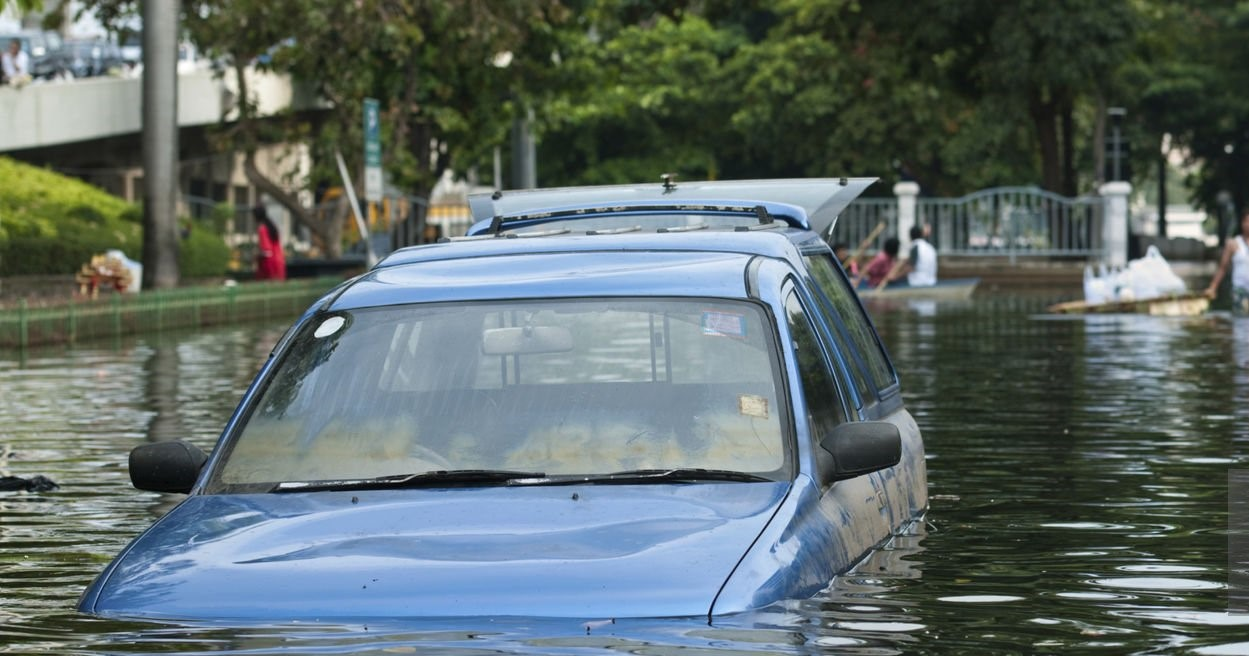
## Table of Contents
- Part 0:  [Project Introduction](#1)
- Part 1:  [Exploratory Data Analysis (EDA) - none NLP](#2)   
  - 1.1  [Import Files and Load Data](#3)
  - 1.2  [Basic Data Inspectations](#4)
  - 1.3  [Deeper EDA](#5)
    - 1.3.1 [Dependent Variable Distribution](#6)
    - 1.3.2 [Null/Missing Values and feature analysis](#7)
- Part 2:  [Exploratory Data Analysis (EDA) - NLP](#8)
  - 2.1:  [Tweets, Word Clouds and Unique Words](#9)
  - 2.2: [NLP Meta Features](#10)
  - 2.3: [N Grams](#11)
- Part 3: [Data Preprocessing](#12)
- Part 4: [Model Building and Training](#15)
  - 4.1 [Baseline Model](#16)
  - 4.2 [Model Tuning 1 - Recurrent Model LSTM](#17)
  - 4.3 [Model Tuning 2 - Add GloVe Embedding](#18)
  - 4.4 [Model Tuning 3 - Recurrent GRU Model](#19)
- Part 5: [Submit Testing Results](#20)
- Part 6: [Conclusion](#21)
- [References](#22)

Image from [gdagys](https://www.gettyimages.com/search/photographer?photographer=gdagys) from GettyImages

# <a id="1"></a>
<div style="text-align: center; background-color: #527506; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Part 0: Project Introduction 
🌎</h1>

</div>

<div style="background-color: #effdee; padding: 10px;">
<span style="font-size: larger;">

### Dataset Overview 
- The dataset originates from a Kaggle competition project. As mentioned in the [dataset](https://www.kaggle.com/competitions/nlp-getting-started/data) and [project](https://www.kaggle.com/competitions/nlp-getting-started/overview) description, the dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website [here](https://www.appen.com/). There are train.csv (the training set with 7613 records) , test.csv (the testing set with 3263 records), and sample_submission.csv files (the file to update and submit). Each sample in the train and test set has the following information/columns:
  - id (int64): a unique identifier for each tweet
  - text (string): the text of the tweet 
  - location (string): the location the tweet was sent from (may be blank) 
  - keyword (string): a particular keyword from the tweet (may be blank) 
  - target (int64): in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


### Project Goals, Metric and Focus 
- Project goal: This is a classification project. For each Id in the test set, predict if the tweet is a disaster tweet ('1' for yes, '0' for no). For this Kaggle competition, submissions are evaluated on F1 score, which is sort of the average of precision and recall. It's a better metric to use if the data isn't perfectly balanced and if we want a metric to reflect the performance of both precision and recall. 
- Beyond prediction: Tweeter data can be challenge becuase unlike news articles. Because tweeter texts come from users and are usually highly informal, they have more of typos, slang words, abbreviations, special characters, and they are shorter. For this project in particular, we also only have a few thousands of data, which makes the prediction even more challenge. So, besides prediction, this project aims to explore advanced methods in natural language processing (NLP) to overcome these obstacles and to gain insights. 


### Proejct Highlights
- Text preprocessing:
  - I've found that the normal methods of text data cleaning — such as removing stop words, stemming, etc don't work well for this project, we'll discuss in more detail during the project.
- Model Training Approach:
  - Initial Base Run: Initially, we'll start with a non-sequential deep learning model to establish a foundational baseline for predicting house prices. This approach emphasizes thorough data exploration and preprocessing to ensure the model receives quality input.
  - Tuning:
    - To enhance the NLP model's performance, we'll transition to a recurrent neural network (RNN) architecture, specifically Long Short-Term Memory (LSTM). 
    - To mitigate overfitting in the LSTM model, we'll incorporate additional dropout regularization within the RNN cell.
    - To deal with the problem of many words in testing data not in training (partially because of the small training data and natural of tweet data), we'll leverage pre-trained word embeddings GloVe to enriching the model's understanding of textual features.
    - We'll explore the performance of Gated Recurrent Unit (GRU) architectures, providing insights into alternative sequential modeling techniques.


# <a id="2"></a>
<div style="text-align: center; background-color: #527506; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Part 1: Exploratory Data Analysis (EDA) 
🍂</h1>

</div>

##### <a id="3"></a>

<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 1.1: Import Files and Load Data</h2>
</div>

In [1]:
# Import files

# General files
import os
import numpy as np 
import pandas as pd 
import itertools
from scipy.stats import norm, skew, mode
import re
import gc
import string
import warnings 
import operator

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall
from keras import backend as K
import keras_nlp
import keras_core as keras

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

2024-02-29 19:35:22.686024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 19:35:22.686099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 19:35:22.687781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [2]:
# Load data
root_dir = '/kaggle/input/nlp-getting-started'
train=pd.read_csv(os.path.join(root_dir, 'train.csv'))
test=pd.read_csv(os.path.join(root_dir, 'test.csv'))
sample_submission=pd.read_csv(os.path.join(root_dir, 'sample_submission.csv'))


##### <a id="4"></a>

<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 1.2: Basic Data Inspections</h2>
</div>

In [3]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
# rows and column numbers and types
# training sets
print('************************************training data******************************************')
print(train.info())
print('************************************testing data******************************************')
print(test.info())

************************************training data******************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
************************************testing data******************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
No

In [5]:
train.describe(include='all')

id     keyword location  \
count    7613.000000        7552     5080   
unique           NaN         221     3341   
top              NaN  fatalities      USA   
freq             NaN          45      104   
mean     5441.934848         NaN      NaN   
std      3137.116090         NaN      NaN   
min         1.000000         NaN      NaN   
25%      2734.000000         NaN      NaN   
50%      5408.000000         NaN      NaN   
75%      8146.000000         NaN      NaN   
max     10873.000000         NaN      NaN   

                                                     text      target  
count                                                7613  7613.00000  
unique                                               7503         NaN  
top     11-Year-Old Boy Charged With Manslaughter of T...         NaN  
freq                                                   10         NaN  
mean                                                  NaN     0.42966  
std                                                   NaN     0.49506  
min                                                   NaN     0.00000  
25%                                                   NaN     0.00000  
50%                                                   NaN     0.00000  
75%                                                   NaN     1.00000  
max                                                   NaN     1.00000


### Basic EDA observations ⛈

- Training data has **7613 rows and 5 columns**. Testing data has **3263 rows and 4 columns**. The difference is training data has a 'target' column, which indicates if the twit is disaster or non-disaster.
- There are **61 'keyword' and 2472 'location' null values** in training data. There are **26 'keyword' and 1150 'location' null values** in training data.


##### <a id="5"></a>

<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 1.3: Deeper EDA - non NLP</h2>
</div>

##### <a id="6"></a>

<div style="text-align: center; background-color: #70ced0; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 1.3.1: Dependent Variable Distribution</h2>
</div>

Text(0.5, 1.0, 'Positive 1 (Disaster Tweets) Percentage: 43.0%')

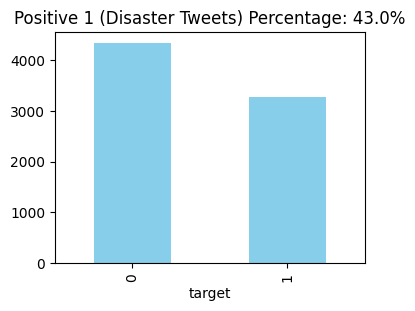

In [6]:
# check the balance of dependent variable
plt.figure(figsize=(4, 3))
train.target.value_counts().plot(kind='bar',color='skyblue')
plt.title(f'Positive 1 (Disaster Tweets) Percentage: {round(train.target.value_counts()[1]/train.shape[0]*100,0)}%')

Seems in training set, the data is a bit imbalanced (but not terrible) with around **43% positive (disaster tweets) samples**. Since the metric for this competition is F1 score ($ \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} $), which is around the average of precision and recall, a little dependent variable imbalance is probably fine.

#### Now let's check message length distribution by disaster vs. non-disaster tweets.

Negative "Message Length" skewness: 0.068573 and kurtosis: -0.733013
Positive "Message Length" skewness: 0.104245 and kurtosis: 0.339425


/tmp/ipykernel_1612/1697750402.py:16: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


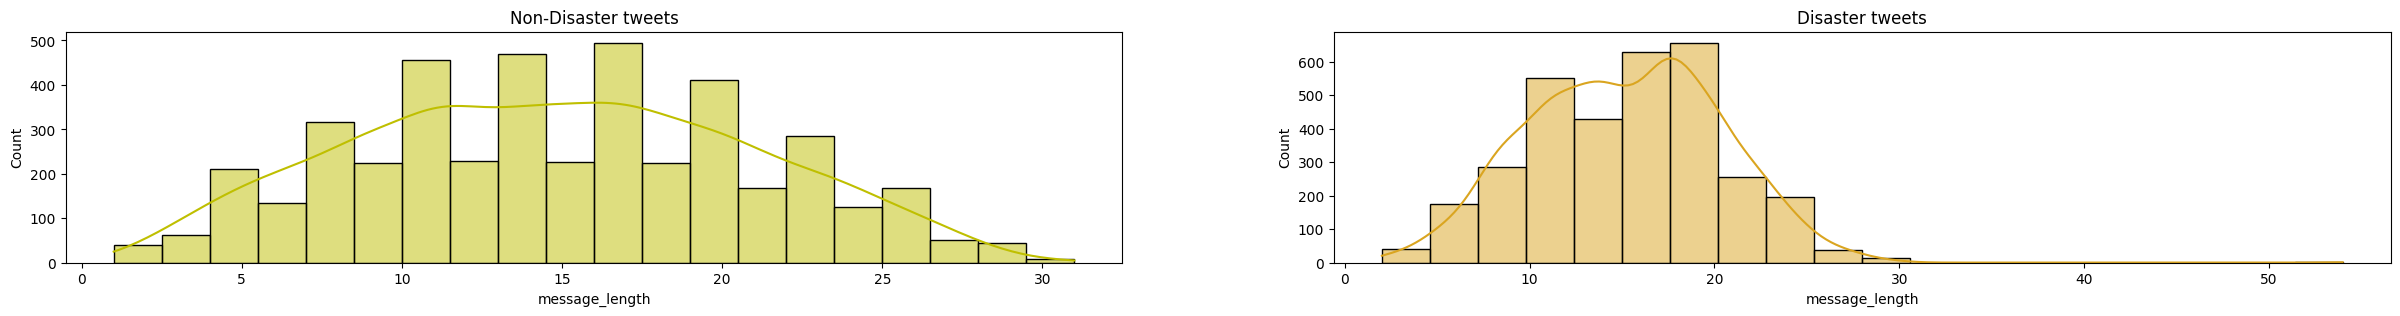

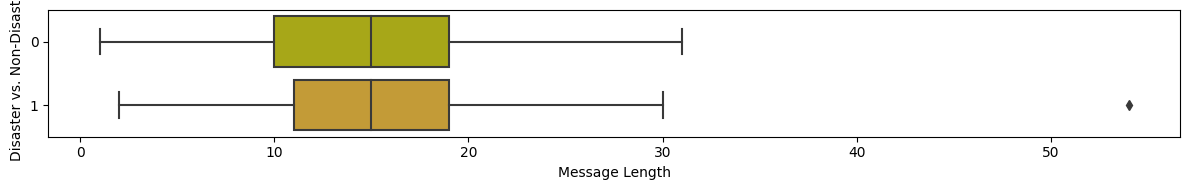

In [7]:
# Create 'message_length' field in copy of train data
def plot_message_length(df):
        df_copy = df.copy()
        df_copy['message_length'] = df_copy['text'].apply(lambda x: len(x.split(" ")))
        #Check skewness & kurtosis of message length dependent variable 
        print("Negative \"Message Length\" skewness: %f and kurtosis: %f" % 
              (df_copy[df_copy['target'] == 0]['message_length'].skew(), 
               df_copy[df_copy['target'] == 0]['message_length'].kurt()))

        print("Positive \"Message Length\" skewness: %f and kurtosis: %f" % 
              (df_copy[df_copy['target'] == 1]['message_length'].skew(), 
               df_copy[df_copy['target'] == 1]['message_length'].kurt()))

        #Check distribution 
        plt.figure(figsize=(30,3))
        with pd.option_context('mode.use_inf_as_na', True):
            plt.subplot(1, 2, 1)
            sns.histplot(df_copy[df_copy['target'] == 0]['message_length'], kde=True, bins=20, color='y')
            plt.title("Non-Disaster tweets")

            plt.subplot(1, 2, 2)
            sns.histplot(df_copy[df_copy['target'] == 1]['message_length'], kde=True, bins=20, color='goldenrod')
            plt.title("Disaster tweets")
  
        plt.figure(figsize=(12, 2))
        sns.boxplot(data=df_copy, y='target', x='message_length', palette={0: 'y', 1: 'goldenrod'}, orient='h')
        plt.xlabel('Message Length')
        plt.ylabel('Disaster vs. Non-Disaster')
        
        plt.tight_layout()
        plt.show()
        
plot_message_length(train)

### Postive and Negative target tweets Observations ⛈
- Both disaster and on-disaster tweets are short texts and the **majority of them have 0 to 30 words and centered around 15**. They have nearly symmetric distributions.
- The **disaster tweets** distribution has **heavier tails and a sharper peak** compared to the normal distribution. It has **some outliers of 50 to 55 length**. The non-disaster tweets has lighter tails and a flatter peak.

##### <a id="7"></a>

<div style="text-align: center; background-color: #70ced0; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 1.3.2: Null/Missing Values and feature analysis</h2>
</div>

Check null values. (Also, it's a good practice to check duplicates too)

In [8]:
print('************************************training data******************************************')
print('null values:\n',train.isnull().agg(['sum','mean'], axis=0))
print('Duplicated rows: ',train.duplicated().sum(axis=0))
print('Duplicated IDs: ',train.id.duplicated().sum(axis=0))
print('************************************testing data******************************************')
print('null values:\n',test.isnull().agg(['sum','mean'], axis=0))
print('Duplicates rows: ',train.duplicated().sum(axis=0))
print('Duplicated IDs: ',test.id.duplicated().sum(axis=0))
train_pos=train[train['target']==1]
train_neg=train[train['target']==0]
print('************************************training data - non-disaster******************************************')
print('null values:\n',train_pos.isnull().agg(['sum','mean'], axis=0))
print('************************************training data - disaster ******************************************')
print('null values:\n',train_neg.isnull().agg(['sum','mean'], axis=0))


************************************training data******************************************
null values:
        id    keyword    location  text  target
sum   0.0  61.000000  2533.00000   0.0     0.0
mean  0.0   0.008013     0.33272   0.0     0.0
Duplicated rows:  0
Duplicated IDs:  0
************************************testing data******************************************
null values:
        id    keyword     location  text
sum   0.0  26.000000  1105.000000   0.0
mean  0.0   0.007968     0.338645   0.0
Duplicates rows:  0
Duplicated IDs:  0
************************************training data - non-disaster******************************************
null values:
        id   keyword     location  text  target
sum   0.0  42.00000  1075.000000   0.0     0.0
mean  0.0   0.01284     0.328646   0.0     0.0
************************************training data - disaster ******************************************
null values:
        id    keyword    location  text  target
sum   0.0  19.000000  1

- Overall, we have around 0.8% keyword and 33.3% location missing. 
- Disaster tweets have a bit more keyword missing 1.3% (vs. 0.4% for non-disaster)

### 'location'feature deeper look

In [9]:
# check if 'location' missing values are positive or negative in 'target' value
print("*************************Null values in location************************")
train.groupby('target')['location'].apply(lambda x: x.isnull().sum())

*************************Null values in location************************


target
0    1458
1    1075
Name: location, dtype: int64

Number of unique locations: 3342


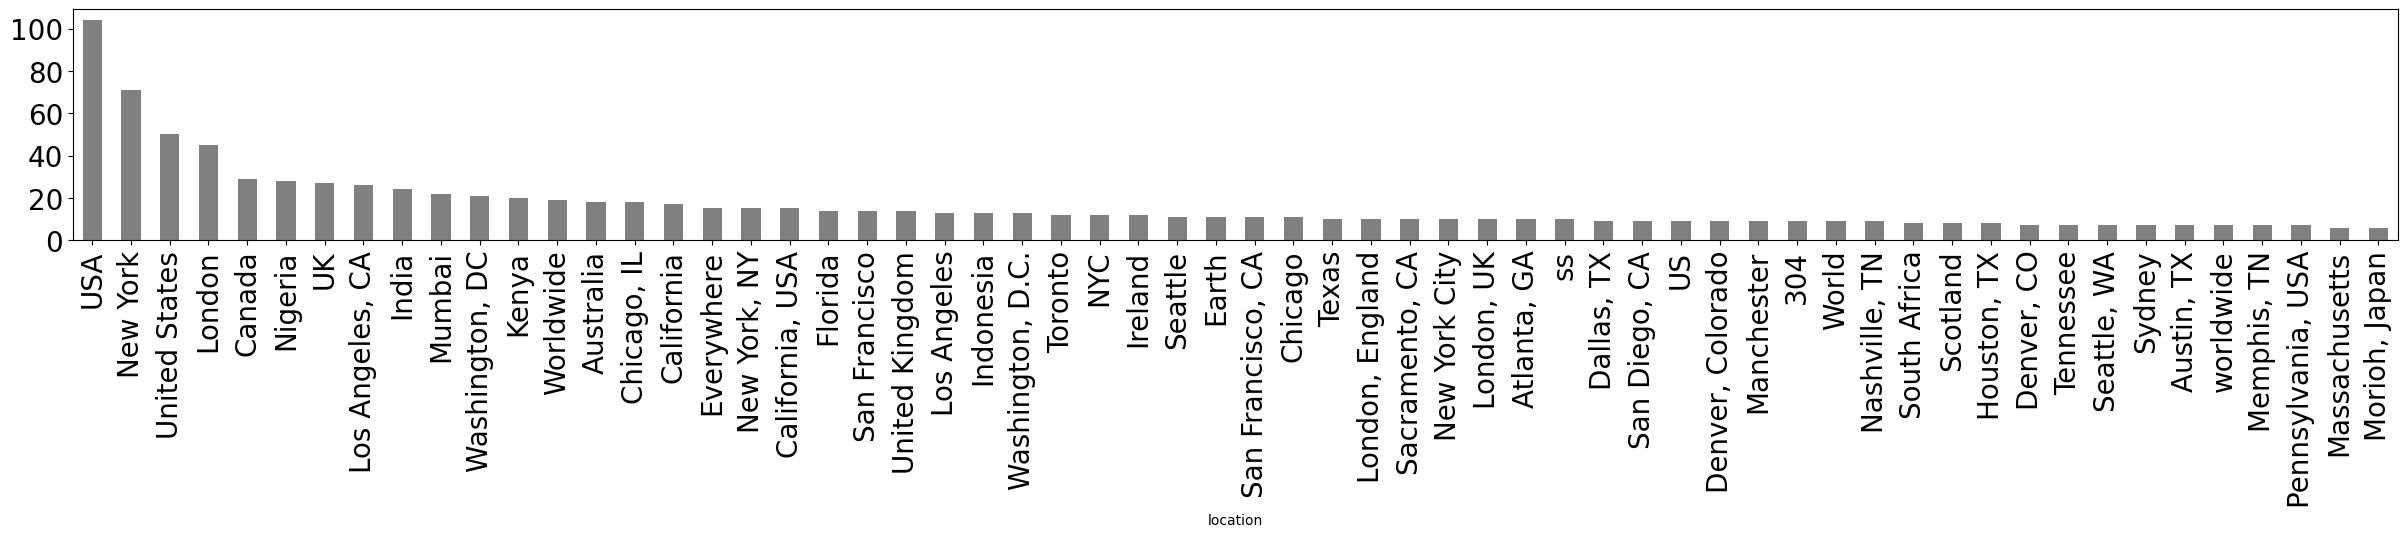

In [10]:
# 'Location' distribution
print(f'Number of unique locations: {len(train.location.unique())}')
plt.figure(figsize=(30,3))
train.location.value_counts().head(60).plot(kind='bar',color='gray',fontsize=20)
plt.show()

Seems **'location' field** is **a bit messy**. Some tweets has state and some don't, some typos, and different 'location' represent the same thing (for example, 'NYC' vs. "New York"). I am not sure this field would contribute to predicting the positive or negative disaster tweets or just add noise. We will probably need to **exclude** this.

### 'keyword'feature deeper look

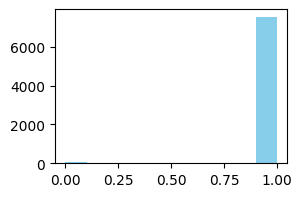

In [11]:
# check 'keyword' length
df_copy = train.copy()
df_copy['keyword_length'] = df_copy['keyword'].apply(lambda x: len(str(x).split(" ")) if pd.notna(x) else 0)
plt.figure(figsize=(3,2))
df_copy['keyword_length'].hist(color='skyblue')
plt.grid(False)

In [12]:
# Take a look at keywords in df
train[train['keyword'].isnull()==False].sample(5)

id          keyword  location  \
6998  10035          twister  Plano,TX   
4857   6916  mass%20murderer       NaN   
3614   5159            fatal       NaN   
5531   7889      quarantined     china   
1005   1458   body%20bagging       316   

                                                   text  target  
6998  @briannafrost Twister with Bill Paxton and Hel...       0  
4857  You happen to conveniently 'forget' about how ...       1  
3614  11-Year-Old Boy Charged With Manslaughter of T...       1  
5531  Top link: Reddit's new content policy goes int...       0  
1005  'I did another one I did another one. You stil...       1

In [13]:
# Unique keywords
print('unique keywords in training:', len(train['keyword'].unique()))
print('unique keywords in testing:', len(test['keyword'].unique()))
print('unique keywords in testing not in training:', len( set(test['keyword'].unique()) - set(train['keyword'].unique())))
print('unique keywords in trainingnot in testing :', len( set(train['keyword'].unique()) - set(test['keyword'].unique())))

unique keywords in training: 222
unique keywords in testing: 222
unique keywords in testing not in training: 0
unique keywords in trainingnot in testing : 0


- **'keyword' feature only has one word per record**. 
- There are **222 unique ones** in each **training and testing** data and they have the **same unique keywords**. 

 Those probably means the keyword converys very important information. Let's take a closer look at keyword distributions in disaster vs. non-disaster tweets.

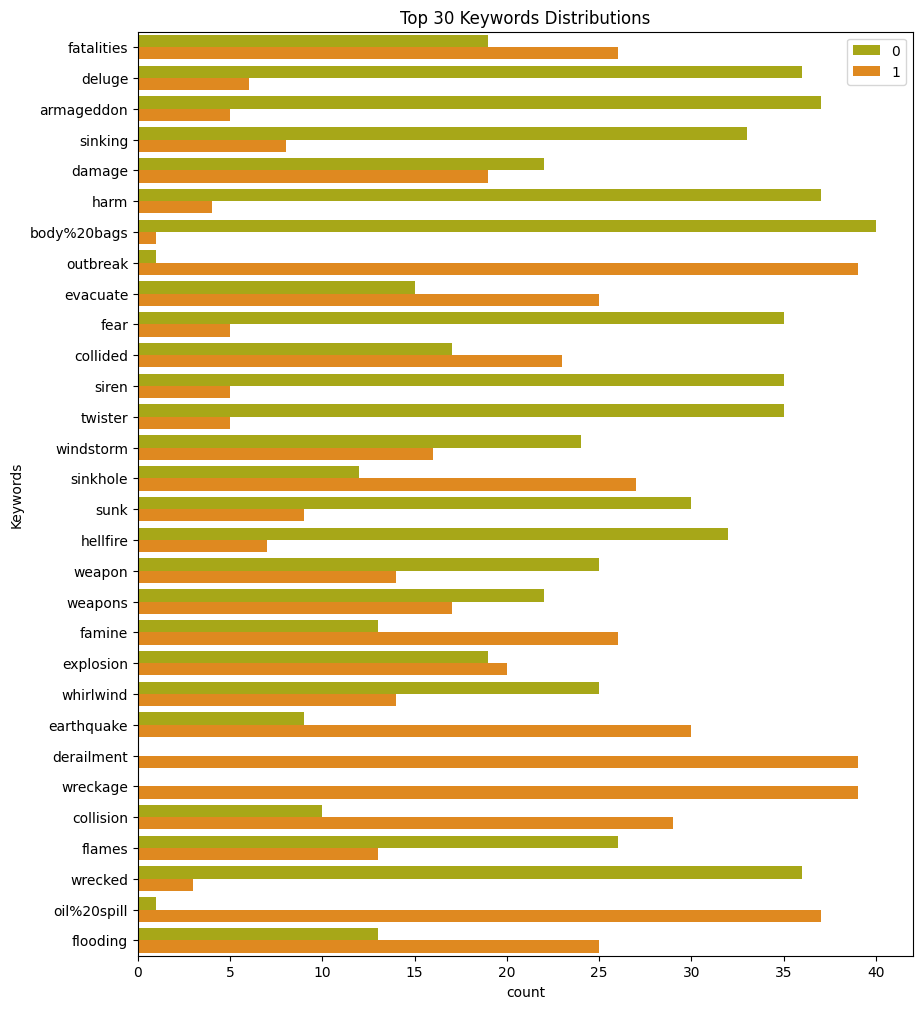

In [14]:
# Plot keywords by disaster (1) vs. non-disaster (0) tweets
plt.figure(figsize=[10, 12])
sns.countplot(y='keyword', 
              data=train,
              order=train['keyword'].value_counts()[:30].index,
              hue='target',
              palette=['y', 'darkorange']).set(title='Top 30 Keywords Distributions', 
                                                      ylabel='Keywords')

plt.legend()
plt.show();

- It does seem for most keywords, the distributions are **quite different for disaster vs. non-disaster tweets**. This confirms that this field could indeed really helpful for our prediction!



### Deeper EDA (non- NLP specific observations) summary ⛈
    
- Target variable is a bit imbalanced (but not terrible) with around **43% positive samples**. It's probably fine since the competition is going to use F1 score, which is balanced between precision and recall. 
- The majority of positive and negative target groups have **0 to 30 words**. 
- The **positive target group**'s distribution has **heavier tails and a sharper peak** compared to the normal distribution, while the negative target group's distribution has lighter tails and a flatter peak.
- **Disaster tweets have a bit more keyword missing 1.3%** (vs. 0.4% for non-disaster)
- **'location'** field is a bit **messy and might not useful**.
- **'key word'** field has one keyword per record. There are **the same 222 unique keywords in both training and testing data**. Those keywords **convery important information** about tweet contents. 
-  However, I've tried to add 'keyword' to the end of the text to improve model prediction performance. While it doens't hurt the performance too much, it doesn't help. I will leave them out (and for simplicity I've deleted the part I used them). :(

# <a id="8"></a>
<div style="text-align: center; background-color: #527506; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Part 2: Exploratory Data Analysis (EDA) - NLP
☃️</h1>

</div>

##### <a id="9"></a>

<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 2.1:  Tweets, Word Clouds and Unique Words</h2>
</div>

## <font color='green'>What does Disaster and Non-disaster Tweets look like?</font>


In [15]:
# Take a look waht texts for each 'Category' looks like
print('********************************Disaster tweets********************************')
print(train[train['target']== 1]['text'].iloc[0],'\n')
print(train[train['target']== 1]['text'].iloc[1],'\n')
print(train[train['target']== 1]['text'].iloc[2],'\n')

print('********************************Non-Disaster tweets********************************')
print(train[train['target']== 0]['text'].iloc[0],'\n')
print(train[train['target']== 0]['text'].iloc[1],'\n')
print(train[train['target']== 0]['text'].iloc[2],'\n')


********************************Disaster tweets********************************
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

Forest fire near La Ronge Sask. Canada 

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 

********************************Non-Disaster tweets********************************
What's up man? 

I love fruits 

Summer is lovely 



## <font color='green'>Word Cloud!😃</font>

It's fun to use "word cloud" to get a sense of what frequent word in data looks like!

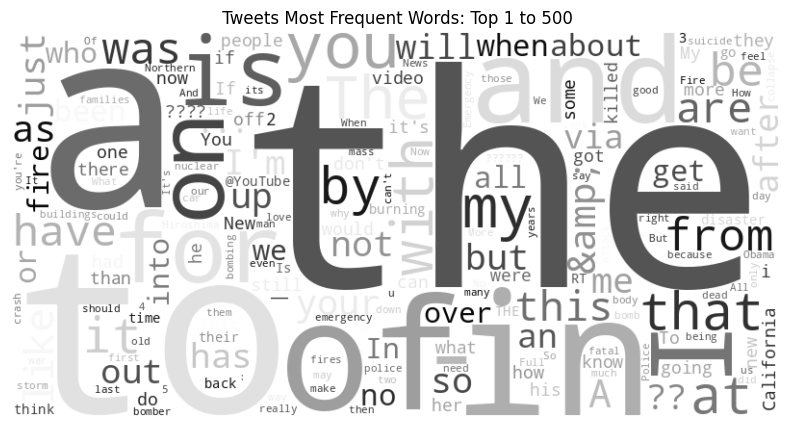

In [16]:
# Word Cloud 

def generate_wordcloud(df, start, end, colormap='viridis',target='', word='Words'):
    frequency = df.str.split().explode().value_counts()
    words = frequency.index[start:end].tolist()
    counts = frequency.values[start:end].tolist()
    wordcloud_dict = {words[i]: counts[i] for i in range(len(words))}
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap=colormap).generate_from_frequencies(wordcloud_dict)
    
    plt.figure(figsize=(12, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{target} Tweets Most Frequent {word}: Top {start+1} to {end}')
    plt.axis('off')
    plt.show()

generate_wordcloud(train['text'], 0, 500, colormap= 'gray')

From a quick glance, we know many words aren't meaningful. They are **mostly 'stop words'**. However, as mentioned in project introduction, it's good to keep them. In sequential model, they help to determine the meaning of sentences.

## <font color='green'>Unique Words?</font>


For a language model, words inherently carry meanings. Without leveraging external embeddings, typically trained on extensive corpora, a model can solely learn word embeddings from its training data. If a word appears in the testing data that wasn't encountered during training, it's often deemed an out-of-vocabulary (OOV) word and consequently ignored during the testing stage. Therefore, it's crucial to verify whether words in the testing data also appeared in the training data, especially when relying solely on embeddings derived from our training data.

Words in training: 32017
Words in testing: 17426
Words in testing not in training: 9823
Words in both testing and training: 41747


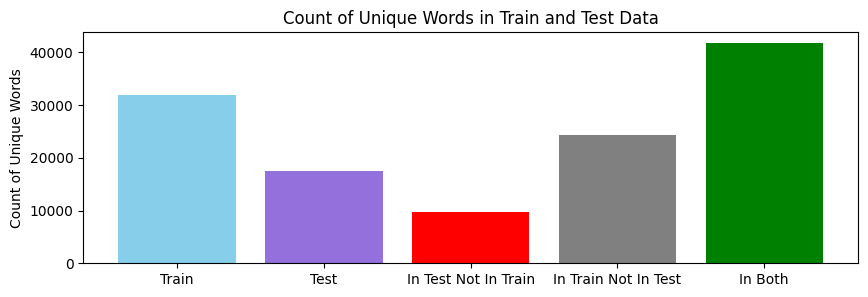

Some sample words in testing not in training:
 ['http://t.co/3m7amh1E33', 'layers', 'statesmanlike', 'Nuks.', 'boys!', '@jfwong', 'us)', '@zerohedge', "'DAMNNNN", '#nfl', 'sir...', 'http://t.co/XUnS3zHIxa', 'hav...', 'DeSean', 'cnnbrk', 'Microsoft\x89Ûªs', 'WOMB', 'sympathyONLF', "Ol'Head", 'alredy.', 'http://t.co/BZUnEPsuLP', 'appealing', '#Auspol', 'Expecte...', 'catering', 'https://t.co/tdeS8MEAR2', 'isnt', '@ibrahimdubashi', 'Atgames', 'http://t.co/2ZGrVnMDW9', '*anti', '@rainierarms', '#nvidia', 'Keio', "BeyoncÌ©'fy", '411Naija', "LIFE'", 'busiest', 'http://t.co/ozoD1fdgas', 'Amazing!', 'Hvy', "'Now", 'closure', 'hotel', 'Yup', '#CityofCalgary', 'http://t.co/OcAdC8vFyF', 'bath.', 'Ulzzang', 'http://t.co/PMv8ZDFnmr', 'WOUNDED', 'http://t.co/YszIBvj3cs', 'county.', 'magically', 'Italians', 'quick.', '@WalpurgisNightZ', 'moi', 'Ren', 'Mediterranean.', '#NHS', 'Hickory', 'Corporation.', 'acquisition', 'http://t.co/0NVdzxQ2HF', 'http://t.co/hodWosAmWS', 'affect.', 'http://t.co/O8sTW4YN

In [17]:
def unique_words_train_test(col, n=600):
        # First let's check number of unique words in training and testing
        unique_words_train = len(train[col].str.split(" ").explode().unique())
        unique_words_test = len(test[col].str.split(" ").explode().unique())

        # Find words in test not in train
        unique_words_train_list = set(train[col].str.split().explode().unique())
        unique_words_test_list = set(test[col].str.split().explode().unique())
        words_in_test_not_train = list(unique_words_test_list.difference(unique_words_train_list))
        words_in_train_not_test = list(unique_words_train_list.difference(unique_words_test_list))
        words_in_both_train_and_test = list(unique_words_train_list.union(unique_words_test_list))
        
        # Some output
        print("Words in training:", unique_words_train)
        print("Words in testing:", unique_words_test)
        print("Words in testing not in training:", len(words_in_test_not_train))
        print("Words in both testing and training:", len(words_in_both_train_and_test))

        # plot
        plt.figure(figsize=(10,3))
        plt.bar(['Train', 'Test','In Test Not In Train','In Train Not In Test',"In Both"], [unique_words_train, unique_words_test, len(words_in_test_not_train), len(words_in_train_not_test), len(words_in_both_train_and_test)], 
                 color=['skyblue', 'mediumpurple','red','gray','green'])
        plt.title('Count of Unique Words in Train and Test Data')
        plt.ylabel('Count of Unique Words')
        plt.show()
        
        print("Some sample words in testing not in training:\n", words_in_test_not_train[:n])
unique_words_train_test('text')

    
### Unique Words observations ⛈
    
Although the count of unique words in training and testing data are similar. There are **so many words in testing that aren't in training**. This isn't good because the model wouldn't recognize those words in testing time if we use normal embedding. Let's take a look at what those discrepancy words are. 

I can see a few reasons/issues:
- Things shouldn't be looked as unique words. 
  - **Hyperlinks**: usually starts with 'http:','https:',
  - **Numbers**: "01:02:42", "1945", "40's" for example.
  - **Mentions**: usually start with '@' 
- Things combine with 'word' were treated as a different word:
  - **Punctuations**: 'bags:','Facebook.','now.', 'tonight??', 'meals*', './.....hmm', '\x89Û÷crying' for example. Stemming won't be able to fix this. 
  - **Hashtags**:  '#LA', '#Bombeffects','#German'
- Words in different forms:
  - Words in **different forms**:,'saying','counters', 'snowy' for example.
  - Words in **different higher and lower cases**: 'DYING', 'Amase', 'TALK' for example
  - Typos and repeated single characters:'Nooooooooooooooo','Yesssss', for example
- Special characters:
  - 'her\x89Û_', '#1\x89ÛÒDon\x89Ûªt' for example

  
Okay, overall, it seems we need to do some corpus cleaning!! Before that, let's look at create and look at some NLP "Meta Features".
  

##### <a id="10"></a>

<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 2.2:  NLP Meta Features </h2>
</div>

<div style="background-color: #effdee; padding: 10px;">
<span style="font-size: larger;">
    
#### Meta Features

In NLP, "Meta-features" are additional features or characteristics derived from the data that are used to augment the original dataset for analytical and modeling purposes. Inspired by this [notebook](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert), **disaster tweets tend to have more tweets that are writen in a more formal way** by news agencies. We will now create some 'Meta Features" and compare to see their distriubtions in disaster and non-disaster tweets. Also,we'll look at their distributions in training vs. tesings set because the distribution discrepancy between training and testing can affect testing predictions:
- **word_count**: number of words in text
- **unique_word_count**: number of unique words in text
- **stop_word_count**: number of stop words in text
- **url_count**: number of urls in text
- **mean_word_length**: average character count in words
- **char_count**:number of characters in text
- **punctuation_count**: number of punctuations in text
- **hashtag_count**: number of hashtags (#) in text
- **mention_count**: number of mentions (@) in text

In [18]:
# Source code https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count, I will add a few more I saw in data
stop_words = nltk.corpus.stopwords.words('english')
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w or 'www' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w or 'www' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

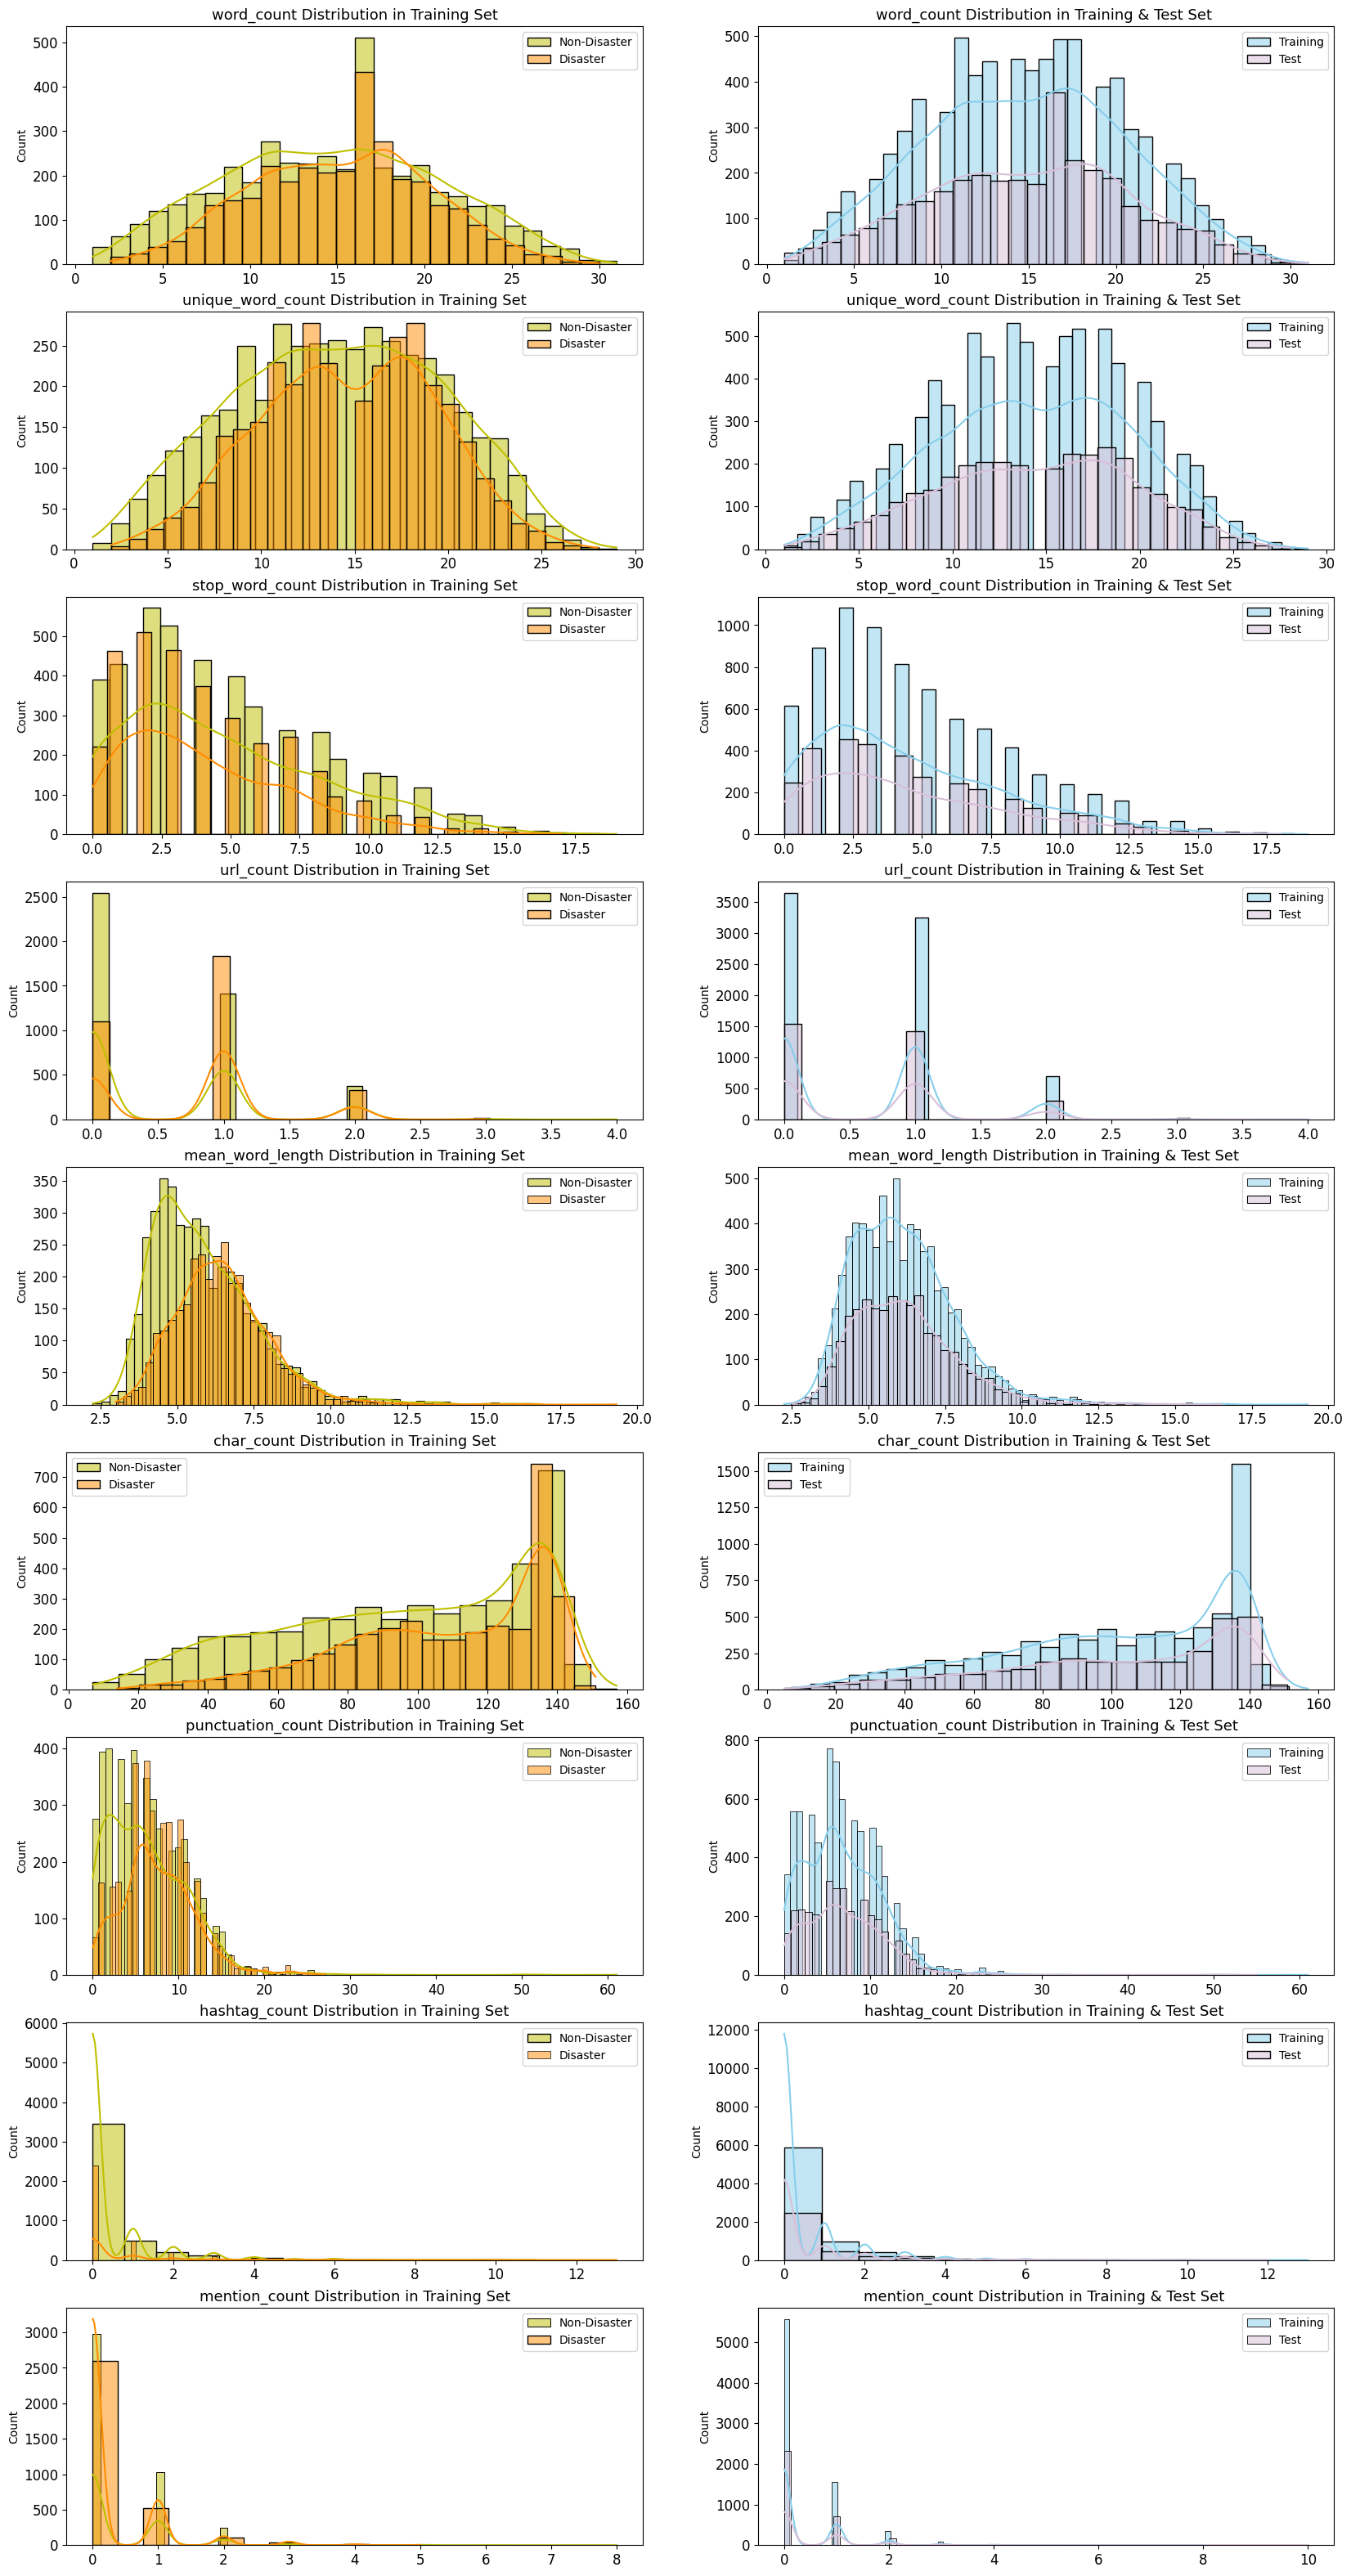

In [19]:
# Source code https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

# histograms for Meta-Features

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning) # Suppress FutureWarning


METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 40), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train.loc[~DISASTER_TWEETS][feature], label='Non-Disaster', ax=axes[i][0], color='y', kde=True)
    sns.histplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='darkorange', kde=True)

    sns.histplot(train[feature], label='Training', ax=axes[i][1], color='skyblue', kde=True)
    sns.histplot(test[feature], label='Test', ax=axes[i][1], color='thistle', kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Distribution in Training & Test Set ', fontsize=13)

plt.show()


### Meta Features observations ⛈
    
From the plots above, alhtough most of the distributions look very similar in disaster vs. non-disaster tweets, we **saw a trend that disaster tweets do tend to have more formal ones**:
- **Non-Disaster tweets have more meanion tags @**
- **Disaster tweets use slightly longer words** ('mean_word_length' is bigger in disaster tweets).
- **Disaster tweets have a bit less low count punctuation (<5) and low count character (<60)** tweets

Also:
- **disaster tweets have more url links**  (more >=1 'url_count' in disaster tweets)
- For some reason, training data seems to have more high character count (around 140) tweets.  

##### <a id="11"></a>

<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 2.3:  N Grams </h2>
</div>

Sometimes, word's meaning won't be preserved if seperate. So, it's useful to check n grams.

In [20]:
def ngram_freqplot(df, color='skyblue', target=" "):
    fig, axs = plt.subplots(1, 3, figsize=(20,10))  
    for i in range(1, 4):
        # Use CountVectorizer to get ngram
        vectorizer = CountVectorizer(ngram_range=(i, i), stop_words='english')
        ngram_train = vectorizer.fit_transform(df['text'])

        # Calculate the frequency of each n-gram and store in dictionary 
        ngram_freq = ngram_train.sum(axis=0)
        feature_names = vectorizer.get_feature_names_out()
        ngram_dict = {feature_names[j]: ngram_freq[0, j] for j in range(len(feature_names))}
        
        # Filter out n-grams containing URLs
        ngram_dict = {ngram: freq for ngram, freq in ngram_dict.items() if not re.match(r'(http|https)', ngram)}
        
        sorted_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)

        # top n-grams 
        top_n = 30  # Adjust the number of top n-grams you want to plot
        top_ngrams = [item[0] for item in sorted_ngrams[:top_n]]
        top_frequencies = [item[1] for item in sorted_ngrams[:top_n]]

        # bar plot
        axs[i-1].barh(top_ngrams, top_frequencies, color=color)
        axs[i-1].set_title(f'{target} tweet top 30 {i}-gram ')
        axs[i-1].invert_yaxis()  # want highest frequency at the top
        axs[i-1].tick_params(axis='x') 

        # font size for the words 
        for tick in axs[i-1].get_yticklabels():
            tick.set_fontsize(15)
    plt.tight_layout()

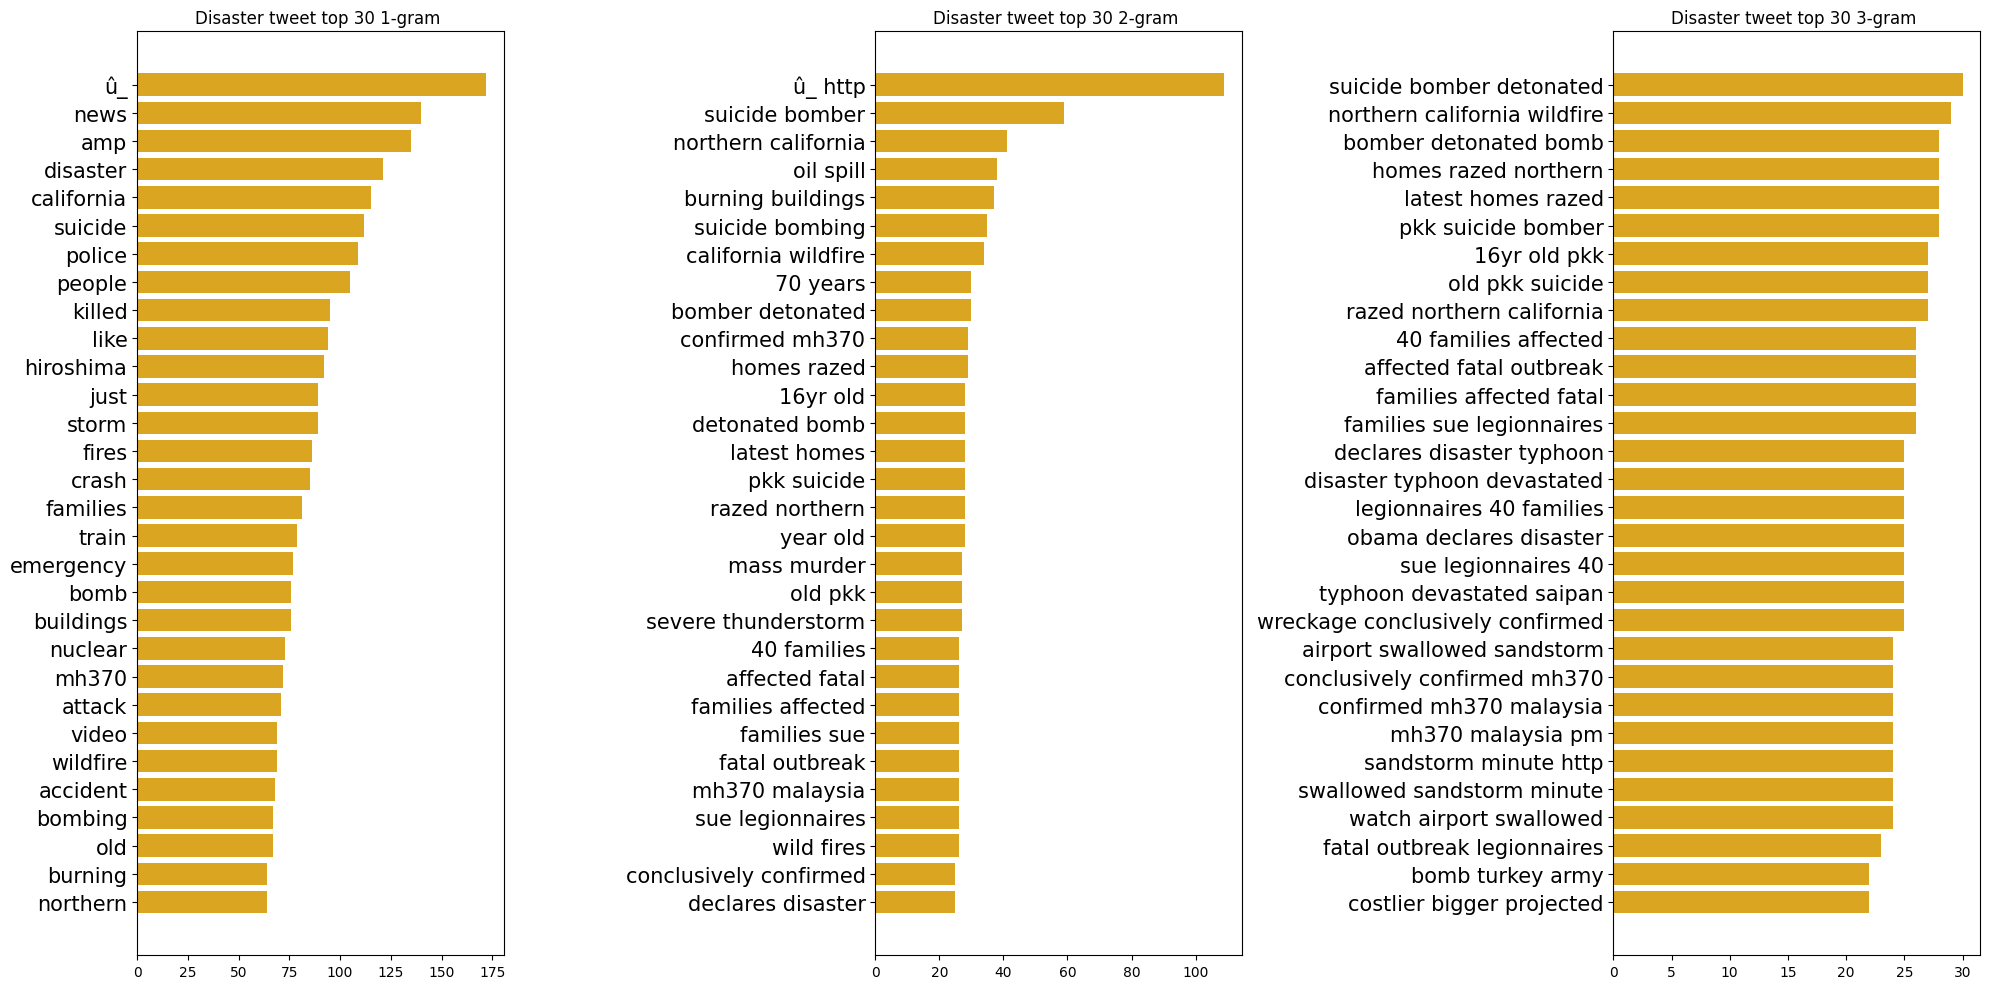

In [21]:
# Disaster tweets
ngram_freqplot(train[train['target']==1], color='goldenrod', target="Disaster")

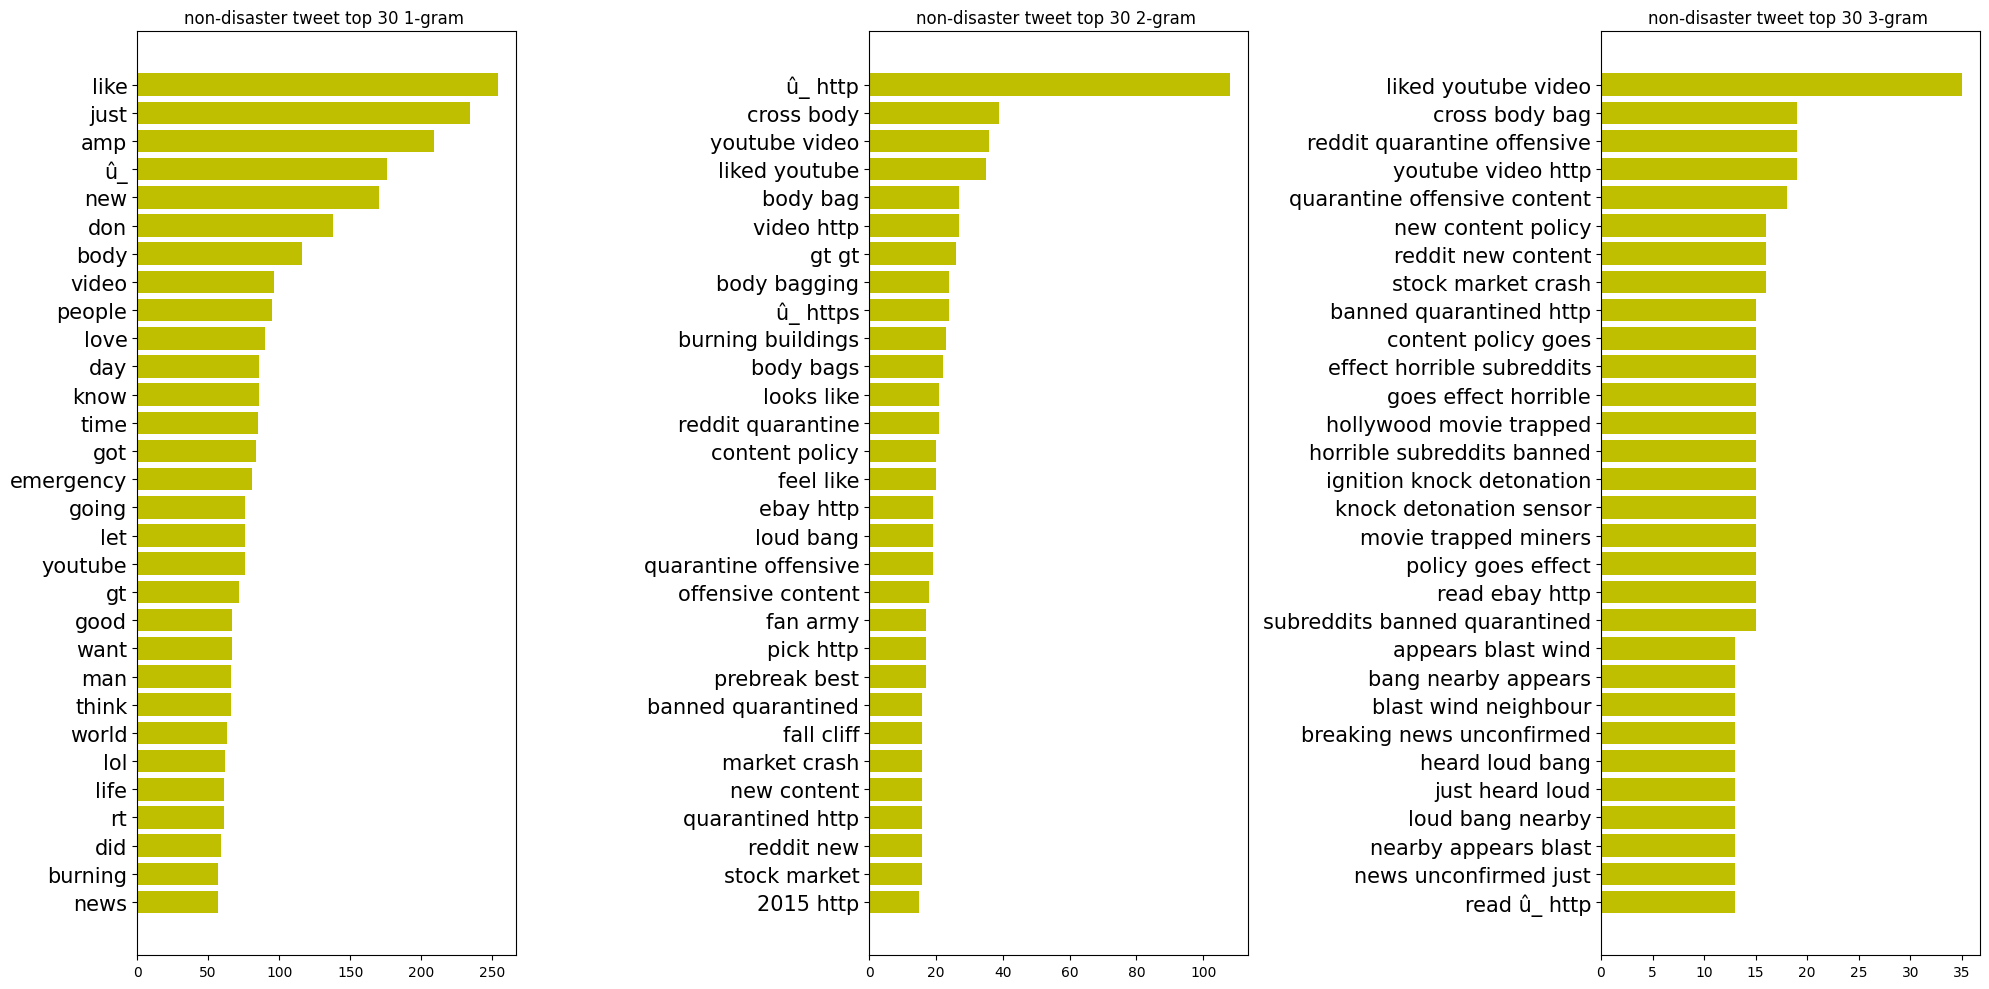

In [22]:
# non-disaster tweets
ngram_freqplot(train[train['target']==0], color='y', target ='non-disaster')

- I can see some related disaster vs. non-disaster unigram and bigram. For example, 'disaster', 'suiside', 'oil spill' are frequent in disaster tweets. While in non-disaster tweets, the frequent words are more light-hearted. I think those would help with predictions. 
- However, many frequent words in disaster and non-disaster tweets don't seem to be helpful. For example, 'like' are frequent in both kinds of tweets.
* Note for frequent words above, I've already excluded 'english' stop-words.

# <a id="12"></a>
<div style="text-align: center; background-color: #527506; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Part 3: Data Preprocessing☔️ </h1>

</div>

<div style="background-color: #effdee; padding: 10px;">
<span style="font-size: larger;">

### Normal text preprocessing methods don't work well here
In EDA, we've seen the tweet messages have many stop words, punctuations, and similar words (that might seem to need some word stemming). However, as mentioned in our project introduction, I've tried several corpus preprocesing (or cleaning) approaches for this project data (although for simplicity, I've deleted them in the project). The lession I learned (at least from the particular models and settings I've tried) is that the normal methods of text data cleaning (such as removing stop words, stemming, converting text to lowercase, and removing punctuation) that work so well maybe in news article data may not be so beneficial for this project's tweet data! My models didn't get good predictions. After experimenting, I noticed that many tweets cleaned with those methods became challenging to understand (at least for human like me), likely due to their inherently informal and abbreviated nature. Since tweet messages are already concise and packed with slang words and abbreviations, traditional cleaning methods could strip away crucial meaning. Moreover, since we're employing a sequential model, retaining words like stop words and punctuation could aid in preserving context and meaning.

### My plan for text cleaning
At the end, from my discovery, I decided to just do a few cleaning:
- Remove the hyperlinks. As we've seen in EDA, they maybe looked as individual 'words'. It will make the word embedding very difficult. Those should be removed for sure.
- For punctunation, as we've seen in the EDA, a word followed by a punctunation may be looked as a different word. For example, '@kaggle' vs. 'kaggle'. To solve this, we will add spaces around punctuations.
- As seen in EDA, there are many '...' that are attached to word and create unknow 'words'. So, for '...', we will replace them with ' ... ' instead of let the above method to make them " . . . ". Also, replace ".."" with " .. ".
- I know because tweets data is messy, many tweet words won't be find in many embedding methods without some corrections. There are many things I could do. For example, correct slangs, typos, abbreviations, and etc. Those are very time consuming although could be really helpful! For simplicity, I am not going to do those for this project.

In [23]:
sample_text='#Hello hi how are you. Nice    day!'
punctuations = '@#!?+&*[]-%:/();$=><|{}^' + "'`"
for p in punctuations:
        sample_text  = sample_text.replace(p, f' {p} ')
print(sample_text)

 # Hello hi how are you. Nice    day ! 


In [24]:
# function for text preprocessing
def text_preprocessing(text):
    """
    This function does in place replacement of data so it won't return anything
    """    
    # remove hyperlinks
    text = str(text)
    text = re.sub(r'((http|https)://\S+)', '', text)

    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')  
        
    # Seperate words from punctuations 
    punctuations = '@#!.?+&*[]-%:/();$=><|{}^' + "'`"
    for p in punctuations:
        text  = text.replace(p, f' {p} ')

     
    return text


In [25]:
# Text preprocessing
train['clean_text']= train['text'].apply(lambda t : text_preprocessing(t))
test['clean_text']= test['text'].apply(lambda t : text_preprocessing(t))

Words in training: 21884
Words in testing: 12939
Words in testing not in training: 5600
Words in both testing and training: 27166


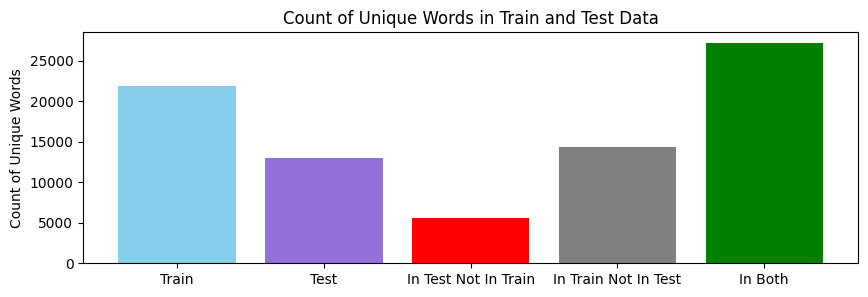

Some sample words in testing not in training:
 ['TheElmagoo', 'layers', 'statesmanlike', 'Incubustour2015', 'DeSean', 'Microsoft\x89Ûªs', 'WOMB', 'sympathyONLF', 'Th', 'appealing', 'ToshikazuKatayama', 'catering', 'isnt', 'LoveThyFamily', 'Atgames', 'Keio', 'Developed', 'Mankind', '411Naija', 'Neill', 'busiest', 'POLLS', 'Hvy', 'Ulzzang', 'aboveandbeyond', 'UPDATE1', 'magically', 'Italians', 'moi', 'blainescronuts', 'Hickory', 'acquisition', 'disrupting', 'bluecurls8', 'Mustang', 'kdudakia', 'HARSH', 'pref', 'dodging', 'thong', 'copolitics', 'CecilTownship', 'Bharat', 'GLS15', 'KoscielnyFC', 'VBAC', 'ElasticaInc', 'Dolakha', 'Howie', 'ShaneRyanHere', 'Sins', 'Sun_OfGod', 'Sudan', 'JRehling', 'Created', 'AlexandBondarev', 'finna', 'OST', 'Tribute', 'Capsule', 'Smartphone', '400', 'differently', 'Braves_Ninja', 'ndtv', 'jamucsb', 'aiden', 'PRO', 'CULINARY', 'Conservatexian', 'D50', 'asthma', 'HOSTAGESTHROSW', 'Infections', 'canon\x89Û_', 'Dorion', 'world\x89Ûªs', 'fplboss', 'Rasheed', 'H

In [26]:
# Now let's take a look again the unique words in training and testing data
unique_words_train_test('clean_text',n=100)

### Unique words after cleaning ⛈
- Unique word count seem to be reduced by around 30%. 
- The test word not appear in train data seems to improved a bit, but the problem still exist significantly.
- Also, there are still many training words not in testing too. This could mean for word embedding, what the model learned in training cannot be applied to testing too.

# <a id="15"></a>
<div style="text-align: center; background-color: #527506; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Part 4: Model Building and Training 🚑 </h1>

</div>

<div style="background-color: #effdee; padding: 10px;">
<span style="font-size: larger;">

    
#### Model Training Approach:
- Initial Base Run: Initially, we'll start with a non-sequential deep learning model to establish a foundational baseline for predicting house prices. This approach emphasizes thorough data exploration and preprocessing to ensure the model receives quality input.
- Tuning:
  - To enhance the NLP model's performance, we'll transition to a recurrent neural network (RNN) architecture, specifically Long Short-Term Memory (LSTM).
  - To mitigate overfitting in the LSTM model, we'll incorporate additional dropout regularization within the RNN cell.
  - To deal with the problem of many words in testing data not in training (partially because of the small training data and natural of tweet data), we'll leverage pre-trained word embeddings GloVe to enriching the model's understanding of textual features.
  - We'll fine-tune the LSTM architecture with optimized dropout inside RNN cells to further refine its performance.
  - We'll explore the performance of Gated Recurrent Unit (GRU) architectures, providing insights into alternative sequential modeling techniques.

#### Things to do before Model training
  - Train/validation split on training data. One important note is that we want to do this before tokenization on words. It's cruicial to not see any testing data either in model training stage or wording tokenization or embedding stage. We don't want the model to learn word embedding on training stage for validation and testing data words. In real world, we won't be able to learn anything from unseen data, so we should keep the validation and testing text strictly from learning in any form in training stage.
  - For Tensor flow, sequences of word need to be in format of same length matrix rows. So a few things to do
    - break strings of sequences to token of words
    - add pad or truncate to make sure each sequences are the same length (pretty much like in CNN, each picture need to be the same input shape)

# <a id="16"></a>
<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 4.1:  Baseline Model </h2>
</div>

We'll just quickly run a baseline non-sequencial model. Without too much thinking, we will just use 2 dense layer and start with grab (from the air) some hyper-parameters to get the model run.The goal isn't get a great model first, but just some starting point for future tuning and model updating.  As discussed above, we will first do a train/validation split. Then, we'll do tokenization, and padding. Note for vacabulary size, I would like to use all words in training. We found in EDA that after cleaning, there are 21884 unique words in training set. We will use that for 'VOCAB_SIZE',


In [27]:
# Train_test split
TEST_SIZE=0.2
y = train['target']
X_train, X_val, y_train, y_val = train_test_split(train, 
                                                      y, 
                                                      test_size=TEST_SIZE, 
                                                      random_state=100) 

In [28]:
# Tokenizer using Tensorflow Keras
VOCAB_SIZE = 21884
OOV_TOKEN ="<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words= VOCAB_SIZE , split=' ', oov_token=OOV_TOKEN)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train['clean_text']) 
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length = max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_val = tokenizer.texts_to_sequences(X_val['clean_text'].values)
padded_val = pad_sequences(sequences_val, maxlen=max_length, truncating='post')

sequences_test = tokenizer.texts_to_sequences(test['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)


Maximum sequence length: 36


We've done the train/validation split, tokenization, and padding. We got the sequences of length 36. we will use this as input_length of all our models. Now, let's build the very first baseline model!

In [29]:
# Build the model
EMBEDDED_DIM = 25
MAX_LEN = max_length
LEARNING_RATE = 0.001

model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDED_DIM,  input_length=MAX_LEN),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 

# Setup the training parameters
initial_learning_rate = LEARNING_RATE

# Compile the model with binary_crossentropy loss, Adam optimizer, and standard metrics
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

# Print the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 25)            547100    
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 dense (Dense)               (None, 6)                 5406      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 552513 (2.11 MB)
Trainable params: 552513 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
NUM_EPOCHS = 5
BATCH_SIZE = 128

# Train the model
history_model1 = model1.fit(padded_train, y_train, epochs=NUM_EPOCHS, validation_data=(padded_val, y_val), batch_size = BATCH_SIZE)

Epoch 1/5
48/48 [==============================] - 2s 15ms/step - loss: 0.6838 - accuracy: 0.5624 - recall: 0.0714 - precision: 0.4452 - val_loss: 0.6765 - val_accuracy: 0.5726 - val_recall: 0.0015 - val_precision: 1.0000
Epoch 2/5
48/48 [==============================] - 0s 8ms/step - loss: 0.6308 - accuracy: 0.6545 - recall: 0.2131 - precision: 0.9285 - val_loss: 0.6084 - val_accuracy: 0.7315 - val_recall: 0.5291 - val_precision: 0.7718
Epoch 3/5
48/48 [==============================] - 0s 7ms/step - loss: 0.4515 - accuracy: 0.8594 - recall: 0.7247 - precision: 0.9336 - val_loss: 0.5081 - val_accuracy: 0.7695 - val_recall: 0.6840 - val_precision: 0.7547
Epoch 4/5
48/48 [==============================] - 0s 7ms/step - loss: 0.2674 - accuracy: 0.9243 - recall: 0.8595 - precision: 0.9603 - val_loss: 0.4823 - val_accuracy: 0.7774 - val_recall: 0.7086 - val_precision: 0.7561
Epoch 5/5
48/48 [==============================] - 0s 8ms/step - loss: 0.1550 - accuracy: 0.9614 - recall: 0.9309 -

In [31]:
# Plot results function
def plot_results(history, model_name="", early_stopping_callback=None):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    titles = [f'{model_name} Accuracy', f'{model_name} Loss', f'{model_name} Precision', f'{model_name} Recall', f'{model_name} F1 Score']
        
    # Calculate F1 score for training and validation data
    train_precision = history.history['precision']
    train_recall = history.history['recall']
    train_f1_scores = [2 * (train_precision[i] * train_recall[i]) / (train_precision[i] + train_recall[i] + 1e-8)
                   for i in range(len(train_precision))]  # Avoid division by zero
    
    val_precision = history.history['val_precision']
    val_recall = history.history['val_recall']
    val_f1_scores = [2 * (val_precision[i] * val_recall[i]) / (val_precision[i] + val_recall[i] + 1e-8)
                     for i in range(len(val_precision))]  # Avoid division by zero
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 15))

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        axs[row, col].plot(history.history[metric])
        axs[row, col].plot(history.history[f'val_{metric}'])
        axs[row, col].set_title(titles[i], fontsize=20)  
        axs[row, col].tick_params(axis='both', which='major', labelsize=20)  
        axs[row, col].legend(['Train', 'Validate'], loc='upper left', fontsize=20)

    # Plot F1 score 
    axs[-1, 0].plot(train_f1_scores)
    axs[-1, 0].plot(val_f1_scores)
    axs[-1, 0].set_title(titles[-1], fontsize=20)  
    axs[-1, 0].tick_params(axis='both', which='major', labelsize=20)  
    axs[-1, 0].legend(['Train', 'Validate'], loc='upper left', fontsize=20)
 
    if early_stopping_callback is not None:
        # return best accuracy and corresponding metrics if early stopping
        val_accuracy = history.history['val_accuracy']
        best_index = np.argmax(val_accuracy)
        best_accuracy = val_accuracy[best_index]
        best_precision = val_precision[best_index]
        best_recall = val_recall[best_index]
        best_f1_score = val_f1_scores[best_index]
        return best_accuracy, best_precision, best_recall, best_f1_score
    else:
        # no early stopping callback
        return history.history['val_accuracy'][-1],  val_precision[-1],val_recall[-1],  val_f1_scores[-1]

    plt.tight_layout()
    plt.show()


model 1 accuracy 0.7820091843605042
model 1 precision 0.7657807469367981
model 1 recall 0.7070552110671997
f1 score 0.735247209355395


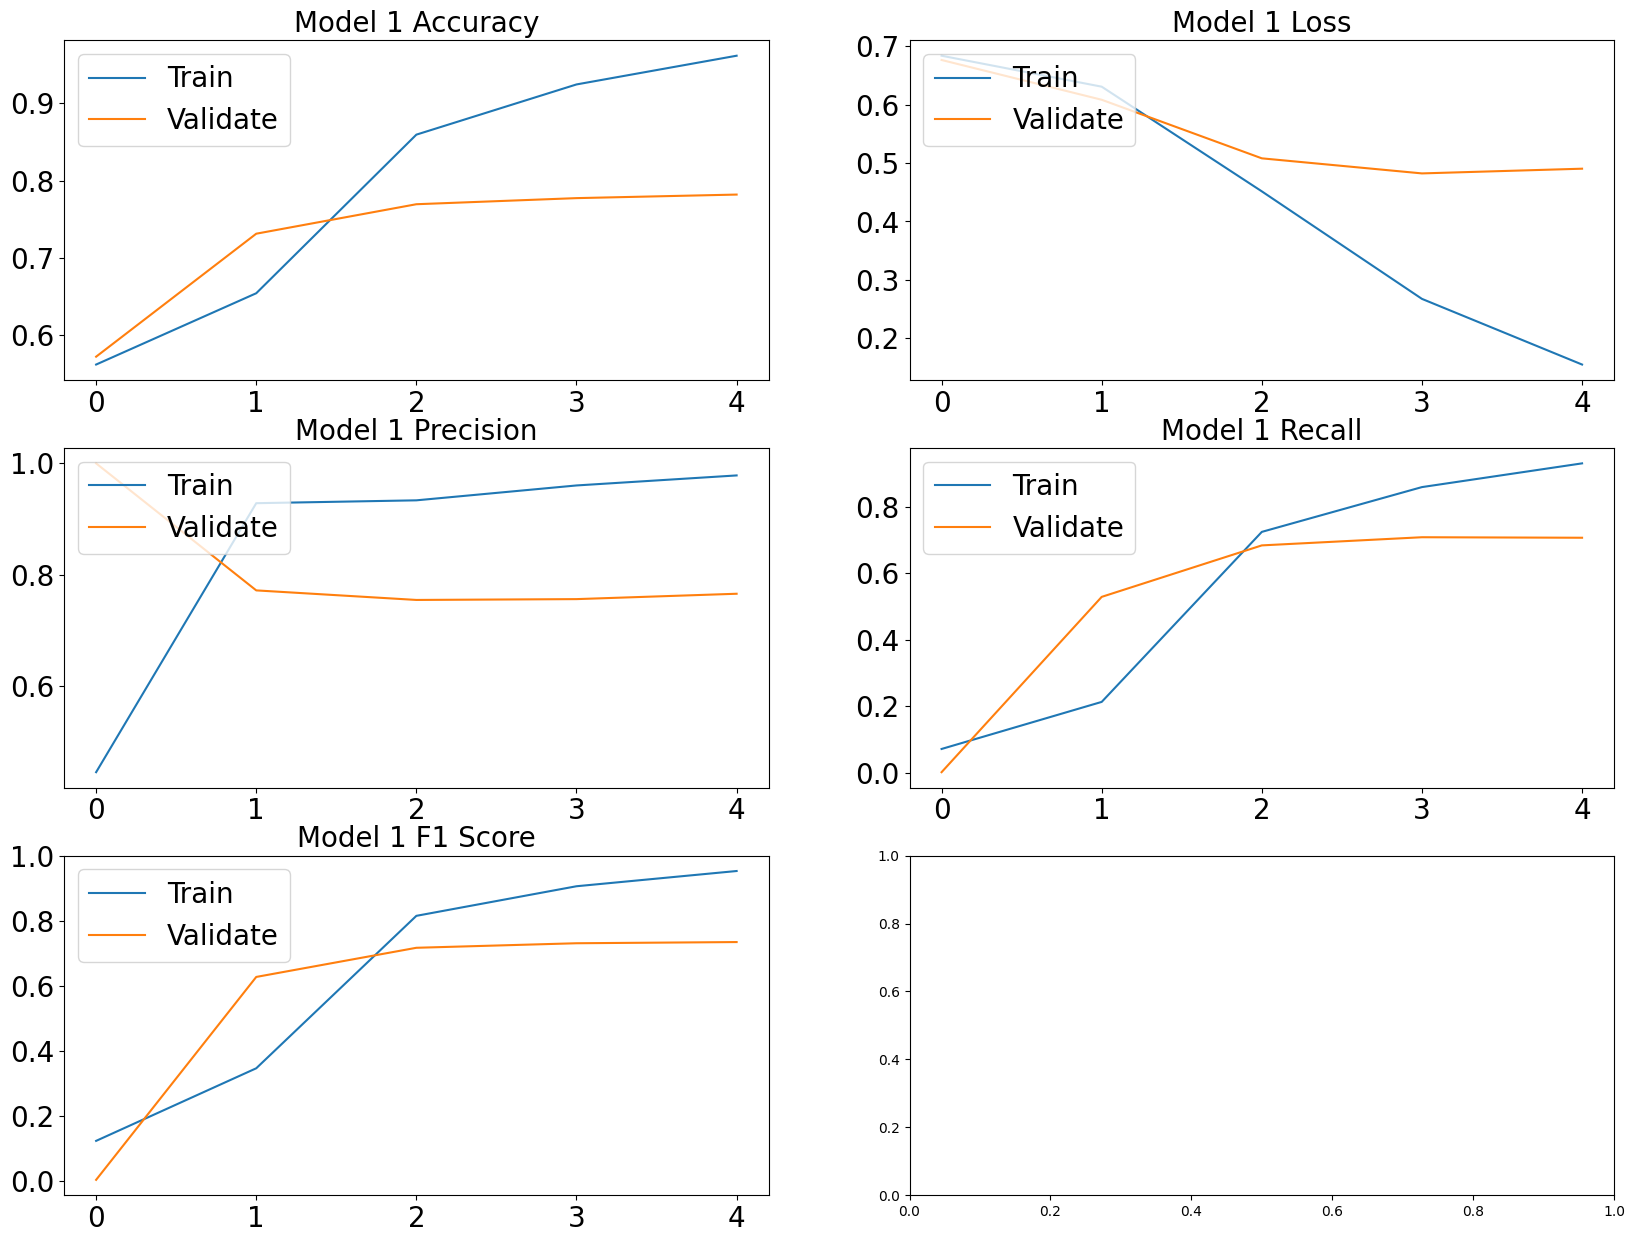

In [32]:
# Plot results 
model1_val_accuracy, model1_val_precision, model1_val_recall ,model1_val_f1_scores = plot_results(history_model1,model_name='Model 1' )
print("model 1 accuracy", model1_val_accuracy)
print("model 1 precision", model1_val_precision)
print("model 1 recall",model1_val_recall)
print("f1 score",model1_val_f1_scores)

48/48 [==============================] - 0s 1ms/step


<Figure size 100x100 with 0 Axes>

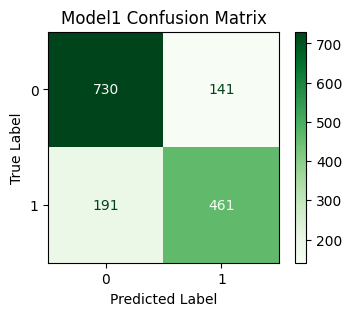

In [33]:
#### Prediction on validation and confusion matrix
def plot_cfm(model, X, y_actual, model_name=""):
        # predictions
        pred_prob = model.predict(padded_val)
        pred_prob = np.transpose(pred_prob)[0]
        y_pred = list(map(lambda x: 0 if x < 0.5 else 1, pred_prob))

        #confusion Matrix
        cfm= confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(1, 1))
        display = ConfusionMatrixDisplay(confusion_matrix=cfm) 
        display.plot(cmap='Greens')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.gcf().set_size_inches(4, 3) 
        plt.show()
        return y_pred
        
y_pred_model1=plot_cfm(model1,X=padded_val, y_actual= y_val, model_name='Model1')

In [34]:
# Take a look at false positive tweets
# Get indices
fp_indices = np.where((np.array(y_pred_model1)== 1) & (y_val == 0))[0]
fn_indices = np.where((np.array(y_pred_model1)== 1) & (y_val == 1))[0]

# False positive
print('****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************')
indices = np.random.choice(fp_indices,10, replace=False)
for i in indices:
    print(f'text{i}\n', X_val.iloc[i]['clean_text'] )
    
#  False negative
print('****************************** Disaster tweets predicted as disaster tweets (False Negative) ***********************************')
indices = np.random.choice(fn_indices,10,replace=False)
for i in indices:
    print(f'text{i}\n',X_val.iloc[i]['clean_text'] )

****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************
text613
 think i ' ll become a businessman a demolish a community centre and build condos on it but foiled by a troupe of multi - racial breakdancers  . 
text549
 I keep sneezing either someone placed a southern dust storm in my house or someone talkin smack
text965
 Ali you flew planes and ran into burning buildings why are you making soup for that man child ?  !   # BooRadleyVanCullen
text916
  # RFP :  Fire Truck Service Body for F - 450  ( Fire fighting rescue  & amp ;  safety equipment Transporta  .  .  .   
text423
 People who say it cannot be done should not interrupt those who are doing it .  ÛÒ George Bernard Shaw
text1112
  @ engineshed Great atmosphere at the British Lion gig tonight .  Hearing is wrecked .  
text185
 A look at state actions a year after Ferguson ' s upheaval 
text984
  # Denver CO  # Insurance  # Job :  Claims Property Field 


### Base Model Performance and Future Tuning Plans ⛈
 
- The baseline model has F1 score of around 0.75! This isn't bad at all. This is a sign the data is at least okay. 
- From the train vs. validation results plot above, we can see the models are highly overfitting. When the training  accuracy keep going up above 0.95 in just 5 epochs, the validation accuracy is around 0.79 and already have shown a trend of going down. 
- As we've discussed, tweeter messages are very short. From EDA, the main portion of them only have around 10 to 30 words! It's hard to use just meaning of individual words to predict the content in such short messages. I think sequential model might help a bit. For example, "nice" in "nice weather today!" isn't the same as "I failed my exame today...nice!'. So, let's try sequntial models (recurrent neural network in particular) next!
- For the first LSTm model, I will use 2 layers of LSTM. LSTM is very complex and slow to train, so 2 layer probably is complex enough to start with. 
- Since for sentences, not only the previous word help with the meaning, but also the future words. Thus, I would like to use bi-directional LSTM instead of single direction.
- Since we know the data is prone to overfitting. For LSTM, I don't expect this to improve immediately without futher tuning, so I will keep epoch numbers as 10 (since more epochs will run more risk of overfitting).
- Also, since I know data and LSTM would likely to overfit, I will have a drop out layer too. 0.2 is often a good number to start with. We can tune this further after we can how it perform. Let's start!


# <a id="17"></a>
<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 4.2:  Model Tuning 1 - Recurrent Model LSTM </h2>
</div>

<div style="background-color: #effdee; padding: 10px;">
<span style="font-size: larger;">
    
### Why Recurrent Nearul Network? How it works?
Recurrent Neural Networks (RNNs) is well-suited for processing sequential data. Recurrent Neural Networks (RNNs) excel in processing sequential data by scanning each sequence from left to right, timestamp by timestamp. At each timestamp, the RNN cell receives input from the current word in the sequence and incorporates information from previous words. For instance, at timestamp 1, the first word is fed into the RNN cell, producing an output. Then, at timestamp 2, the RNN cell takes both the input from the second word and the output from the first timestamp, enabling it to consider context from previous words as well.

This method allows RNNs to capture sequential information effectively, as each timestamp builds upon the understanding gained from preceding timestamps. Moreover, in bidirectional RNNs, information from subsequent sequences is also integrated, enhancing the model's ability to comprehend both past and future contexts. Thus, RNNs are adept at capturing the intricate dependencies present in sequential data.
    
### What is LSTM?
    
- While Recurrent Neural Networks (RNNs) are designed for processing sequential data, they face challenges like the vanishing and exploding gradient problems. While the latter issue is relatively easier to address—often mitigated through techniques like gradient clipping—the former presents a more intricate obstacle. The vanishing gradient problem impedes the flow of information from earlier time steps (or later ones, in the case of bidirectional RNNs) through to subsequent time steps, making it difficult for the model to retain crucial context over extended sequences.

- Long Short-Term Memory (LSTM) networks offer a solution to this challenge by introducing specialized units designed to manage both long-term and short-term memory. LSTM achieves this by incorporating various gates:

  - Forget Gate (Ft): This gate evaluates the relevance of past information in light of the current input, deciding whether to retain or discard long-term memory from previous time steps. By selectively updating the cell state, the forget gate ensures that less pertinent information is discarded.

  - Input Gates (It and Gt): Responsible for regulating the influx of new information into the cell state, these gates jointly determine both the quantity and significance of incoming data. By weighing the relevance of the previous cell state against the current input, these gates dictate how much and what type of new information is integrated into the cell state.

  - Output Gate (Ot): Crucial for controlling the flow of information from the cell state to the output, the output gate dictates which aspects of the current cell state are exposed to the rest of the network. By considering both the previous hidden state and the current input, the output gate governs the update of short-term memory.

- By adeptly managing both long-term and short-term memories through these specialized gates, the LSTM architecture excels at capturing and retaining essential context and dependencies across sequences of varying lengths. 


    
    
    
 

In [35]:
# Build the model 2
# hyper-papameters
EMBEDDED_DIM =25
MAX_LEN = max_length
LEARNING_RATE = 0.0001
DECAY_STEPS = 100 
DECAY_RATE = 0.5
LAYER1_UNIT=64
LAYER2_UNIT=32
DROP_OUT1=0.2
NUM_EPOCHS = 10
BATCH_SIZE = 64


model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDED_DIM,  input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER1_UNIT, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER2_UNIT)),
    tf.keras.layers.Dropout(DROP_OUT1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Compile the model 
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])


model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 36, 25)            547100    
                                                                 
 bidirectional (Bidirection  (None, 36, 128)           46080     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 634461 (2.42 MB)
Trainable params: 63446

In [36]:
# Train the model 
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

history_model2 = model2.fit(padded_train, y_train, epochs=NUM_EPOCHS, 
                            validation_data=(padded_val, y_val), 
                            batch_size=BATCH_SIZE,
                           callbacks= early_stopping_callback)

Epoch 1/10
96/96 [==============================] - 16s 82ms/step - loss: 0.6862 - accuracy: 0.5658 - recall: 0.0157 - precision: 0.3832 - val_loss: 0.6809 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
96/96 [==============================] - 6s 67ms/step - loss: 0.6767 - accuracy: 0.5700 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6689 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
96/96 [==============================] - 6s 62ms/step - loss: 0.5845 - accuracy: 0.6764 - recall: 0.3482 - precision: 0.7755 - val_loss: 0.5024 - val_accuracy: 0.7846 - val_recall: 0.6304 - val_precision: 0.8253
Epoch 4/10
96/96 [==============================] - 6s 63ms/step - loss: 0.3994 - accuracy: 0.8309 - recall: 0.7579 - precision: 0.8337 - val_loss: 0.4571 - val_accuracy: 0.7925 - val_recall: 0.6917 - val_precision: 0.7968
Epoch 5/10
96/96 [==============================] - 6s 62ms/step - loss: 0.3106 - a

### LSTM Model Performance first glance and Future Tuning Plans ⛈
- Well, it seems the LSTM model is no less (if not more) overfitting than non-sequential baseline model! With accuracy on training data went up above 0.96 but accuracy on validation data is around 0.78 although I've added drop outs. This makes sense since LSTM is a more complex model.  
- Since it seem LSTM is severly overfitting, The main focus of hyper-parameter tuning is to address overfitting:
  - I will add drop out layers inside RNN cells too. This seems to really help with LSTM overfitting
  - We will increased drop out rates (after experiment, it seems we need a extremely high rate of 0.8!)
  - We will increase batch size to be 128. I think tweets are very different, it's good to use a bigger batch size so that at each step, the model doesn't adjust the weights based on very small data.
  - We will keep the epoch size small until/unless the overfitting problem is fixed somehow. Increasing epoch size won't help if the model is highly overfit.

## <font color='green'>LSTM Tuning - Add additional drop out inside the RNN Cells</font>

In [37]:
# Build the model 3
# hyper-papameters
EMBEDDED_DIM =25
MAX_LEN = max_length
LEARNING_RATE = 0.0005
DECAY_STEPS = 100 
DECAY_RATE = 0.5
LAYER1_UNIT=64
LAYER2_UNIT=32
DROP_OUT1=0.8
DROP_OUTBI1=0.8
DROP_OUTBI2=0.8
NUM_EPOCHS = 10
BATCH_SIZE = 128


model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDED_DIM,  input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER1_UNIT, return_sequences=True,dropout=DROP_OUTBI1,recurrent_dropout=DROP_OUTBI1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER2_UNIT,  dropout=DROP_OUTBI2,recurrent_dropout=DROP_OUTBI2)),
    tf.keras.layers.Dropout(DROP_OUT1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model 
model3.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])


model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 36, 25)            547100    
                                                                 
 bidirectional_2 (Bidirecti  (None, 36, 128)           46080     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 634461 (2.42 MB)
Trainable params: 63446

In [38]:
# Train the model
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

history_model3 = model3.fit(padded_train, y_train, epochs=NUM_EPOCHS, 
                            validation_data=(padded_val, y_val), 
                            batch_size=BATCH_SIZE,
                           callbacks=early_stopping_callback)

Epoch 1/10
48/48 [==============================] - 25s 205ms/step - loss: 0.6857 - accuracy: 0.5658 - recall: 0.0603 - precision: 0.4633 - val_loss: 0.6822 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
48/48 [==============================] - 9s 185ms/step - loss: 0.6835 - accuracy: 0.5700 - recall: 0.0073 - precision: 0.5000 - val_loss: 0.6811 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
48/48 [==============================] - 9s 179ms/step - loss: 0.6809 - accuracy: 0.5685 - recall: 0.0027 - precision: 0.3043 - val_loss: 0.6714 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
48/48 [==============================] - 9s 196ms/step - loss: 0.6295 - accuracy: 0.6407 - recall: 0.2757 - precision: 0.7127 - val_loss: 0.5845 - val_accuracy: 0.7387 - val_recall: 0.4340 - val_precision: 0.9071
Epoch 5/10
48/48 [==============================] - 9s 179ms/step - loss: 0.501

model 3 accuracy 0.8049901723861694
model 3 precision 0.8086956739425659
model 3 recall 0.7131901979446411
f1 score 0.7579462226968987


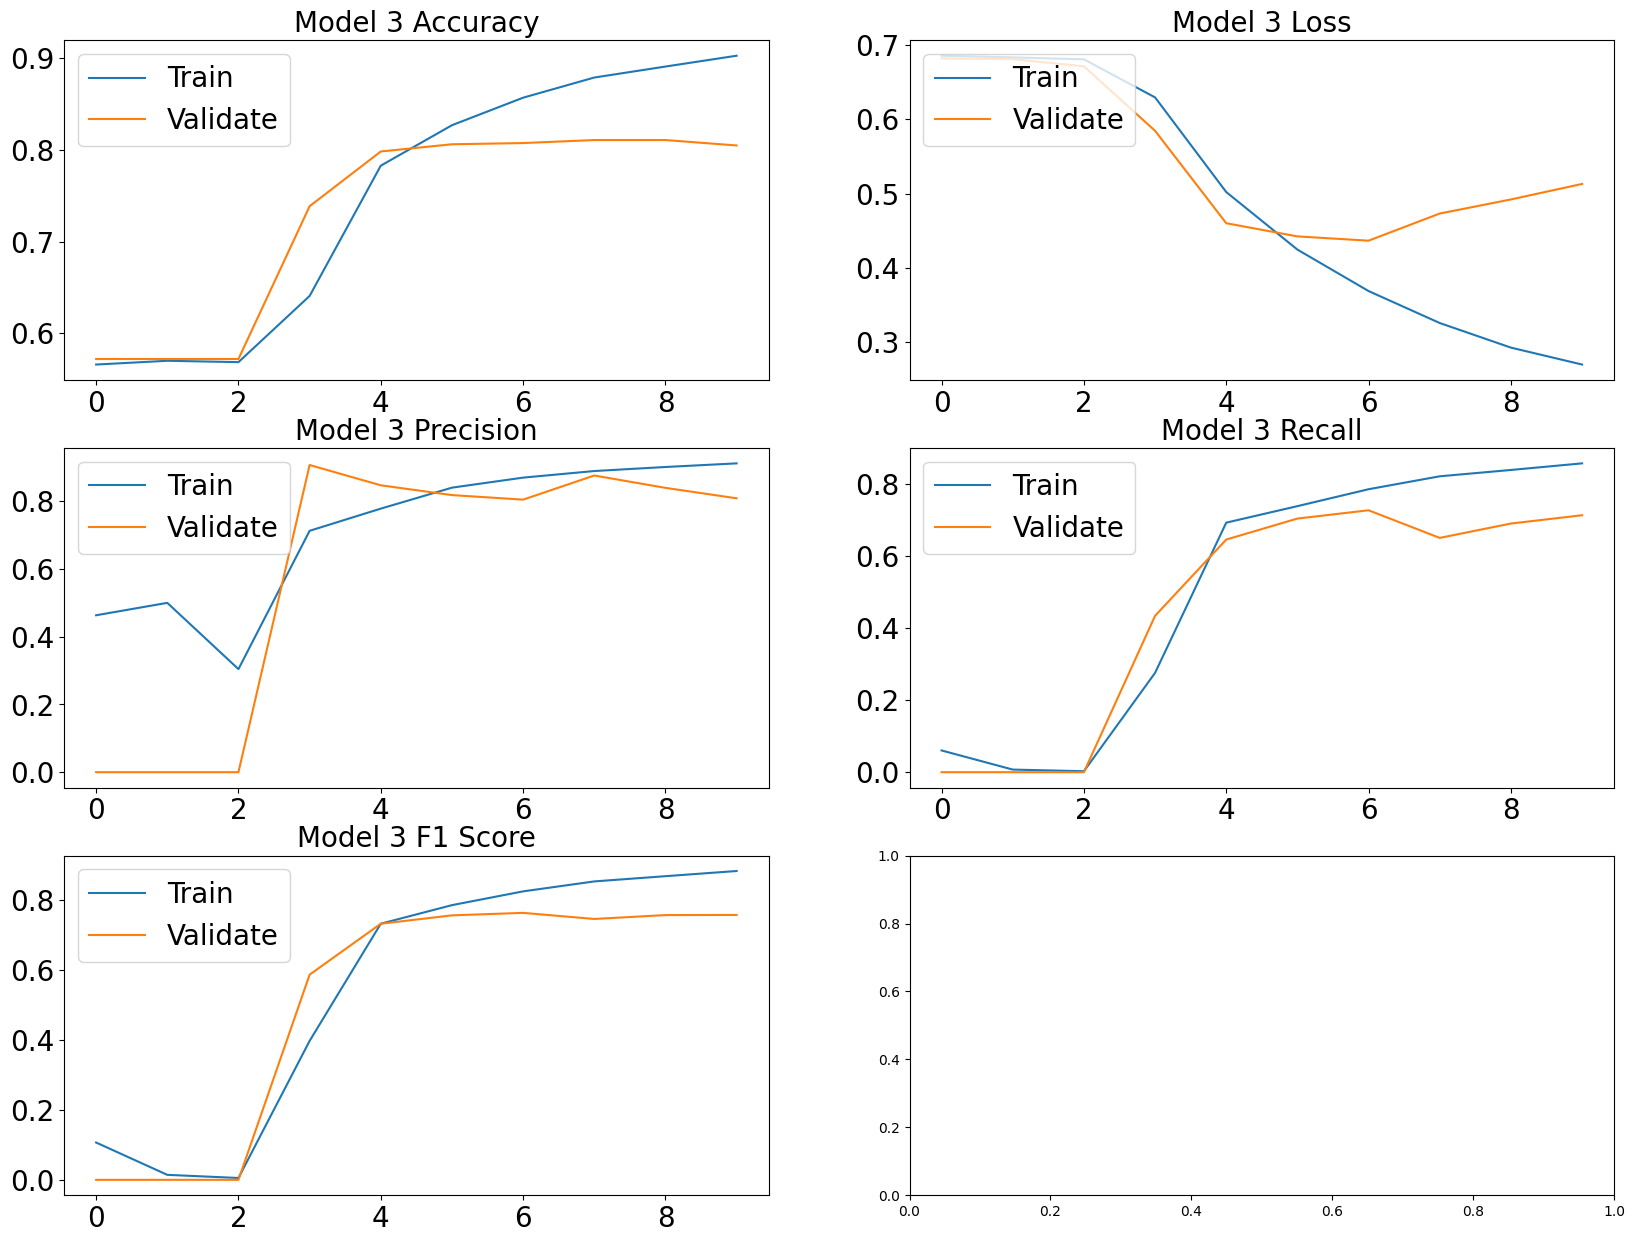

In [39]:
# Plot results
model3_val_accuracy, model3_val_precision, model3_val_recall ,model3_val_f1_scores = plot_results(history_model3,model_name='Model 3' )
print('model 3 accuracy', model3_val_accuracy)
print("model 3 precision", model3_val_precision)
print("model 3 recall",model3_val_recall)
print("f1 score",model3_val_f1_scores)

48/48 [==============================] - 2s 19ms/step


<Figure size 100x100 with 0 Axes>

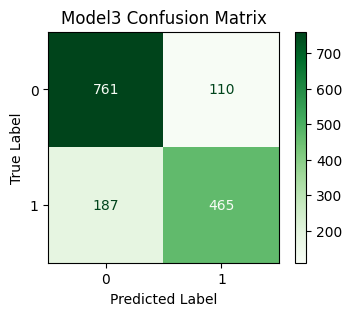

In [40]:
y_pred_model3=plot_cfm(model3,X=padded_val, y_actual= y_val, model_name='Model3')

In [41]:
# Take a look at false positive tweets
# Get indices
fp_indices = np.where((np.array(y_pred_model3)== 1) & (y_val == 0))[0]
fn_indices = np.where((np.array(y_pred_model3)== 1) & (y_val == 1))[0]

# False positive
print('****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************')
indices = np.random.choice(fp_indices,10, replace=False)
for i in indices:
    print(f'text{i}\n', X_val.iloc[i]['clean_text'] )
    
#  False negative
print('****************************** Disaster tweets predicted as disaster tweets (False Negative) ***********************************')
indices = np.random.choice(fn_indices,10,replace=False)
for i in indices:
    print(f'text{i}\n',X_val.iloc[i]['clean_text'] )

****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************
text1065
  @ nagel_ashley  @ Vicken52  @ BasedLaRock  @ goonc1ty rip the world  .  .  .   its burning
text557
  # Tampa :  Super Freestyle Explosion Live in Concert at Amalie Arena  -  Sep  19
 ?  Ticket Info :  
text1328
 Too dangerous for them .  But it ' s OK for the rest of us to be in danger .  
text584
  @ NWSPocatello BG - 16 :  So far brunt of storm just to our north .  Grayed out w /  dust  & amp ;  rain to N blue sky interspersed w /  clouds to S . 
text629
  Articles In Saudi Press Reject Russian Initiative For Regional Alliance With Assad Regime To Fight Terrorism
text539
 HAPPENING NOW  -  HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_ 
text1202
 Who is bringing the tornadoes and floods .  Who is bringing the climate change .  God is after America He is plaguing her
 
 # FARRAKHAN  # QUOTE
text1307
 Court back in session .  Testimo


### Tuned LSTM Model Performance and Future Tuning Plans ⛈
 
- After serval attempts of tuning, the best LSTM F1 score I could get is around 0.75! This isn't better than the baseline model. :(
- Recall (around 0.71) is especailly low or the false negative number (around 180) is especially high. That means, too many disaster tweets are predicted as non-disaster ones. Looking at the tweets identified wrongly above, lots of hash taged words are very short could be one of the reason?
- What can go wrong? It seems LSTM is even more prone to over-fitting than the non-sequential model. One reason I can think of is that our data is very small.  As revealed in our Exploratory Data Analysis (EDA), there's a considerable mismatch between the words present in the testing data and those in the training data. Many words encountered during testing aren't found in the training set, and vice versa. Consequently, during the testing stage, the model encounters numerous out-of-vocabulary words within our current embedding framework. Furthermore, many of the words learned during training aren't effectively utilized during testing, representing a missed opportunity for leveraging the full potential of our model. What a waste! Also, tweet data is very messy as we can see the examples above, lots of slang words, typos, speical characters, and etc.
- To fix this, we will try to leverage pre-trained word embeddings sourced from external corpora. These embeddings have been trained on vast volumes of text, mitigating the issue of discrepancies between training and testing data. By incorporating external word embeddings, we can enrich our model's understanding of language and enhance its ability to generalize across different datasets. This approach holds promise in overcoming the limitations posed by our small dataset and maximizing the utilization of learned word representations for improved performance in real-world scenarios. 
- There are several choice of pre-trained word embeddings. GloVe Embedding is a popular one. We will try this!
- After switching the GloVe, I will keep hyper-parameter the same as before just to see how things go.
- After first run of LSTM with GloVe, I will start to tune hyper-parameters.

# <a id="18"></a>
<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 4.3:  Model Tuning 3 - Add GloVe Embedding </h2>
</div>

<div style="background-color: #effdee; padding: 10px;">
<span style="font-size: larger;">
    
### Global Vectors for Word Representation (GloVe)
- Leverages co-occurrence statistics of word-word to learn word embeddings.

- Words with similar meanings or contexts are closer together in a vector space, while words with different meanings are farther apart. 


In [42]:
# load glove embeddings dictionary
glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)

In [43]:
# check if punctuation is in embeddings
glove_embeddings['@'][:10]


array([-0.66347 ,  1.0426  ,  0.023616,  0.22115 , -0.076111,  0.36219 ,
        0.015835, -0.70007 , -0.26333 ,  0.61526 ], dtype=float32)

In [44]:
# Source code: https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook#4.-Embeddings-and-Text-Cleaning
# check word embedding vocabulary coverage

# Build vocabulary for tweets
def build_vocab(X):
    texts = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for text in texts: 
        for word in text: 
                vocab[word]=  vocab.get(word,0) + 1     
    return vocab

def check_embeddings_coverage(X, embeddings):
    vocab = build_vocab(X)    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train['clean_text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['clean_text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))


GloVe Embeddings cover 80.17% of vocabulary and 96.10% of text in Training Set
GloVe Embeddings cover 83.62% of vocabulary and 95.87% of text in Test Set


In [45]:
# Embedding matrix for GloVe word vectors

# get vacab size from embedding
VOCAB_SIZE = len(glove_embeddings)
EMBEDDED_DIM = len(next(iter(glove_embeddings.values())))
print('vacab size: ', VOCAB_SIZE ,'\n','embedding dim: ', EMBEDDED_DIM )

# Embeddomg matrix from tokenizer created before
embedding_matrix = np.zeros((VOCAB_SIZE,EMBEDDED_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

vacab size:  2196008 
 embedding dim:  300


In [46]:
# after building embedding matrix, glove_embeddings dictionary can be deleted to save memory
del glove_embeddings, train_glove_oov, test_glove_oov
gc.collect()

26453

In [47]:
# Build the model 4
# hyper-papameters
MAX_LEN = max_length
LEARNING_RATE = 0.0005
DECAY_STEPS = 100 
DECAY_RATE = 0.5
LAYER1_UNIT,LAYER2_UNIT =64,32
DROP_OUT1,DROP_OUTBI1,DROP_OUTBI2 =0.8, 0.8, 0.8
NUM_EPOCHS = 10
BATCH_SIZE = 128

model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDED_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_length,
                    trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER1_UNIT, return_sequences=True,dropout=DROP_OUTBI1,recurrent_dropout=DROP_OUTBI1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER2_UNIT,    dropout=DROP_OUTBI2,recurrent_dropout=DROP_OUTBI2)),
    tf.keras.layers.Dropout(DROP_OUT1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model 
model4.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 36, 300)           658802400 
                                                                 
 bidirectional_4 (Bidirecti  (None, 36, 128)           186880    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 659030561 (2.46 GB)
Trainable params: 22

In [48]:
# Train the model 
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

history_model4 = model4.fit(padded_train, y_train, epochs=NUM_EPOCHS, 
                            validation_data=(padded_val, y_val), 
                            batch_size=BATCH_SIZE,
                            callbacks=early_stopping_callback)

Epoch 1/10
48/48 [==============================] - 29s 328ms/step - loss: 0.6873 - accuracy: 0.5547 - recall: 0.3318 - precision: 0.4746 - val_loss: 0.6252 - val_accuracy: 0.6612 - val_recall: 0.2193 - val_precision: 0.9533
Epoch 2/10
48/48 [==============================] - 14s 294ms/step - loss: 0.6388 - accuracy: 0.6371 - recall: 0.4002 - precision: 0.6212 - val_loss: 0.5206 - val_accuracy: 0.7610 - val_recall: 0.6181 - val_precision: 0.7780
Epoch 3/10
48/48 [==============================] - 14s 300ms/step - loss: 0.5667 - accuracy: 0.7186 - recall: 0.5976 - precision: 0.7034 - val_loss: 0.4877 - val_accuracy: 0.7899 - val_recall: 0.7822 - val_precision: 0.7413
Epoch 4/10
48/48 [==============================] - 15s 307ms/step - loss: 0.5362 - accuracy: 0.7494 - recall: 0.6617 - precision: 0.7303 - val_loss: 0.4586 - val_accuracy: 0.8089 - val_recall: 0.7638 - val_precision: 0.7843
Epoch 5/10
48/48 [==============================] - 14s 300ms/step - loss: 0.5287 - accuracy: 0.7578

### LSTM Model with GloVe Performance first glance and Future Tuning Plans ⛈
- Before any further tuning, I can already see an huge improvement in overfitting. The accuracy on training is 0.78 and the accuracy on testing is 0.8247! It seems we have an underfitting problem rather than overfitting? This is a sign that GloVe is working since in our previous LSTM model, we used very big dropout percentage of 0.8 for the model to fit the best! Now, a drop out of 0.8 is clearly too much.
- Next, let's tune the LSTM model with GloVe embedding to it's best. Since the overfitting problem improved significantly and we now has some underfitting problem, the hyper-parameter tuning will focus on addressing the underfitting:
  - The first thing to tune is for sure to lower the drop out ratio!😁. The previous high drop out ratio of 0.8 will prevent the model to learn complex relationships so the training accuracy is low. After some experiment, I found 0.3 now works best.
  - We will increase the epoch numbers too to 18. For the same reason, since overfitting problem was reduced after using GloVe, I found it's good to train the model longer. With early stopping, we are ensured to get the best results.

## <font color='green'>LSTM with Glove tuning </font>

In [49]:
# Build the model 4

# hyper-papameters
MAX_LEN = max_length
LEARNING_RATE = 0.0005
DECAY_STEPS = 100 
DECAY_RATE = 0.5
LAYER1_UNIT,LAYER2_UNIT =64,32
DROP_OUT1,DROP_OUTBI1,DROP_OUTBI2 =0.3,0.3,0.3
NUM_EPOCHS = 18
BATCH_SIZE = 128

model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDED_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_length,
                    trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER1_UNIT, return_sequences=True,dropout=DROP_OUTBI1,recurrent_dropout=DROP_OUTBI1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER2_UNIT,    dropout=DROP_OUTBI2,recurrent_dropout=DROP_OUTBI2)),
    tf.keras.layers.Dropout(DROP_OUT1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model 
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

model4.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])


model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 36, 300)           658802400 
                                                                 
 bidirectional_6 (Bidirecti  (None, 36, 128)           186880    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 659030561 (2.46 GB)
Trainable params: 22

In [50]:
# Train the model 
history_model4 = model4.fit(padded_train, y_train, epochs=NUM_EPOCHS, 
                            validation_data=(padded_val, y_val), 
                            batch_size=BATCH_SIZE, 
                            callbacks=[early_stopping_callback])

Epoch 1/18
48/48 [==============================] - 30s 329ms/step - loss: 0.5709 - accuracy: 0.7163 - recall: 0.5502 - precision: 0.7238 - val_loss: 0.4491 - val_accuracy: 0.8076 - val_recall: 0.7178 - val_precision: 0.8111
Epoch 2/18
48/48 [==============================] - 15s 307ms/step - loss: 0.4457 - accuracy: 0.8059 - recall: 0.7060 - precision: 0.8178 - val_loss: 0.4079 - val_accuracy: 0.8188 - val_recall: 0.7025 - val_precision: 0.8481
Epoch 3/18
48/48 [==============================] - 15s 304ms/step - loss: 0.4264 - accuracy: 0.8156 - recall: 0.7190 - precision: 0.8295 - val_loss: 0.4022 - val_accuracy: 0.8175 - val_recall: 0.7040 - val_precision: 0.8438
Epoch 4/18
48/48 [==============================] - 23s 484ms/step - loss: 0.4162 - accuracy: 0.8204 - recall: 0.7201 - precision: 0.8393 - val_loss: 0.4049 - val_accuracy: 0.8162 - val_recall: 0.6764 - val_precision: 0.8647
Epoch 5/18
48/48 [==============================] - 14s 297ms/step - loss: 0.4060 - accuracy: 0.8314

model 4 accuracy 0.8273144960403442
model 4 precision 0.8359240293502808
model 4 recall 0.7423312664031982
model 4 f1 score 0.7863525515324761
48/48 [==============================] - 2s 23ms/step


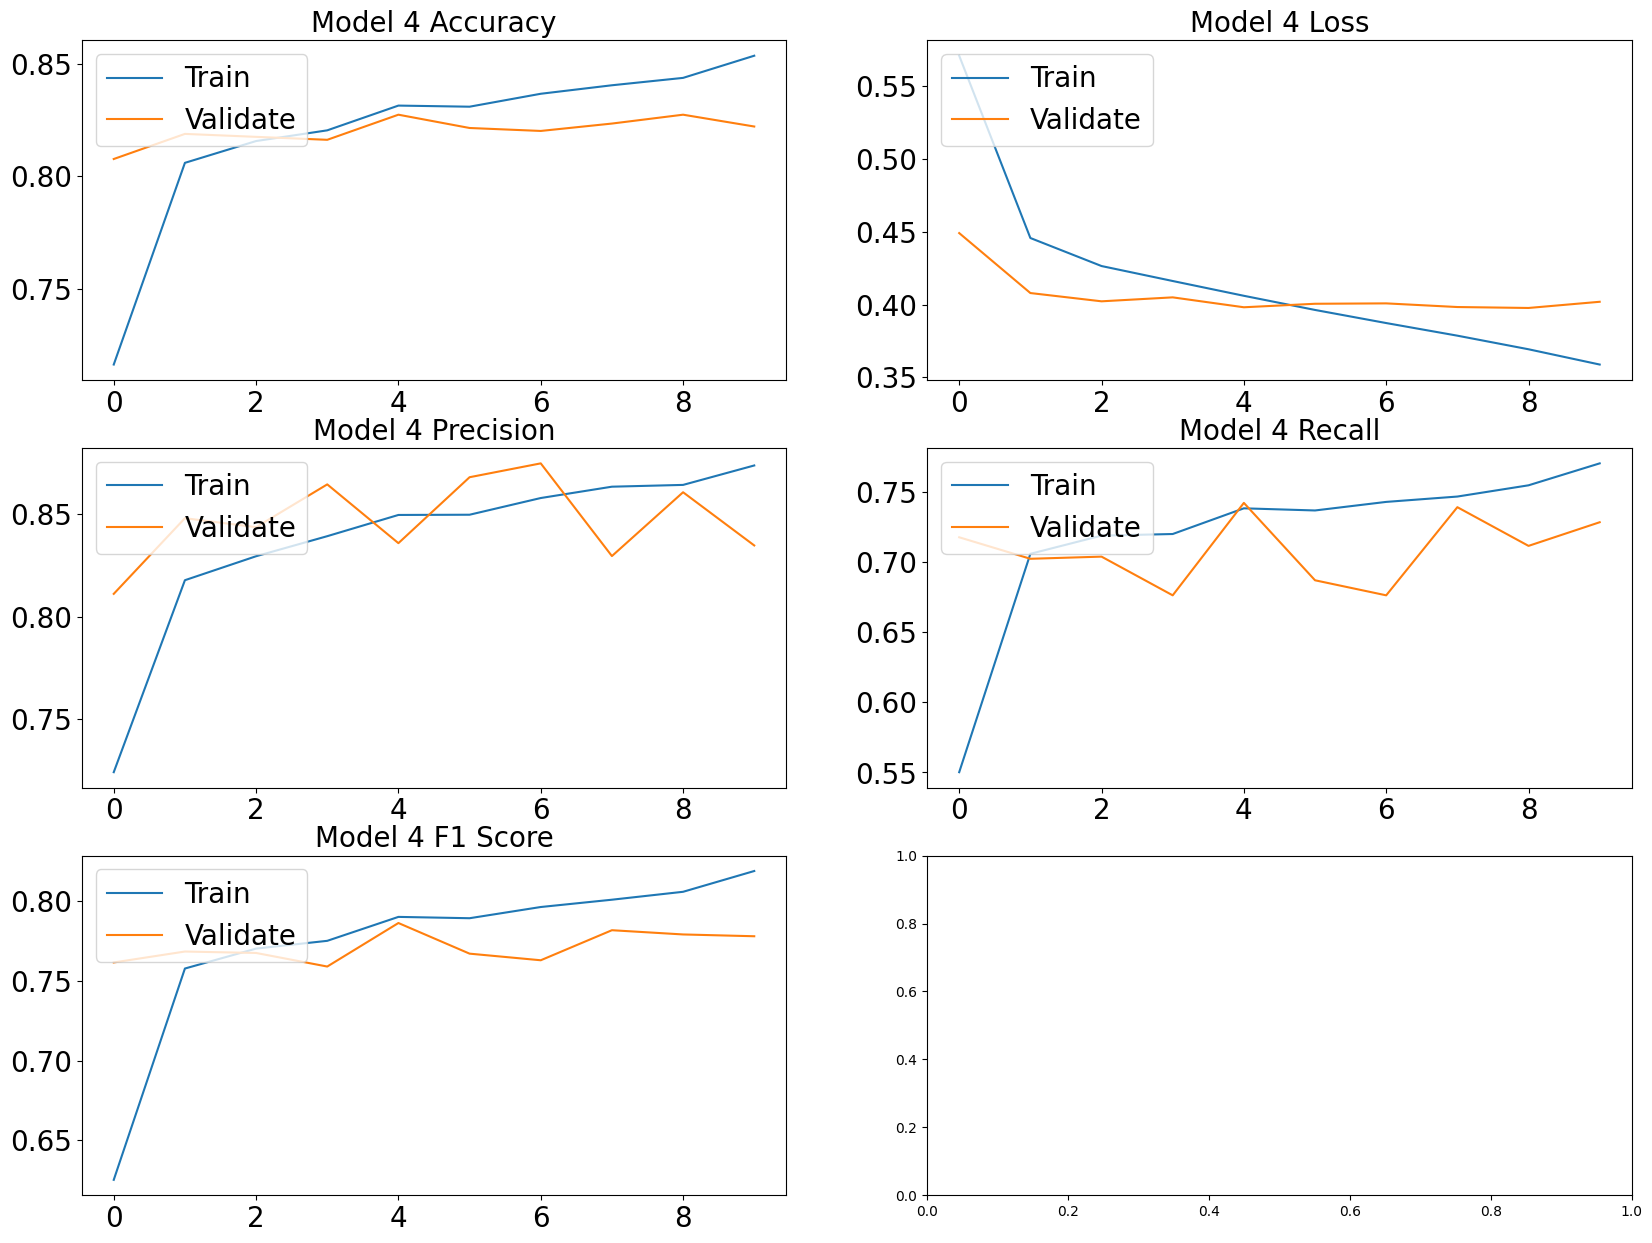

<Figure size 100x100 with 0 Axes>

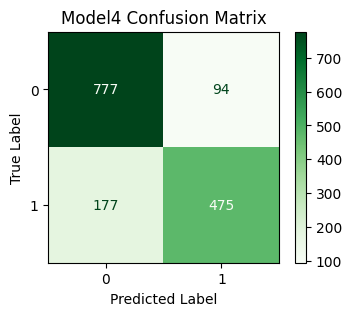

In [51]:
# Plot results
model4_val_accuracy, model4_val_precision, model4_val_recall ,mode41_val_f1_scores = plot_results(history_model4,model_name='Model 4', early_stopping_callback=early_stopping_callback )
print("model 4 accuracy", model4_val_accuracy)
print("model 4 precision", model4_val_precision)
print("model 4 recall",model4_val_recall)
print("model 4 f1 score",   mode41_val_f1_scores )

y_pred_model4=plot_cfm(model4,X=padded_val, y_actual= y_val, model_name='Model4')

In [52]:
# Take a look at wronly predicted tweets
# Get indices
fp_indices = np.where((np.array(y_pred_model4)== 1) & (y_val == 0))[0]
fn_indices = np.where((np.array(y_pred_model4)== 1) & (y_val == 1))[0]

# False positive
print('****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************')
indices = np.random.choice(fp_indices,10, replace=False)
for i in indices:
    print(X_val.iloc[i]['clean_text'] )
    
# False negative
print('****************************** Disaster tweets predicted as disaster tweets (False Negative) ***********************************')
indices = np.random.choice(fn_indices,10,replace=False)
for i in indices:
    print(X_val.iloc[i]['clean_text'] )

****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************
WHEN U BOMBED AND U TRY 2 GET HOME FOR CURFEW 
Today was such a hastle from getting drug tested  blood drown out  tb shot  to document filling   ?  ? 
Who is bringing the tornadoes and floods .  Who is bringing the climate change .  God is after America He is plaguing her
 
 # FARRAKHAN  # QUOTE
Brian Shaw  +  J . J .  Hickson  +  Kenneth Faried trying to defend LaMarcus Aldridge was A BLOOD VOLCANO 
 @ Reuters people like you should be charged after the inevitable rioting for contributing to it with your lies
 @ _wildfire__  ?  ?  ?  ?  Bruh that ' s the lady from Mulan !  ! 
 # Islamic  # state issue a new holiday  # brochure lovely swimming pool for drowning in shooting range and the downside it costs a  # bomb
Savs contact fell out but she was convinced it didnt  & amp ;  went on to guage her eyeball out  & amp ;  now shes having a panic attack over c


### Tuned LSTM Model with GloVe Performance and Future Tuning Plans ⛈
 
- After serval attempts of tuning, the best LSTM with GloVe F1 score is around 0.79. It's a significant improvement to previous LSTM (around 0.75) without GloVe! I think GloVe works!
- After just a few epochs, accuracy of both training and testing data is around 0.85/0.82. This is a good sign that the overfitting and underfitting problems are solved to the best for the model and embedding we have.
- Although F1 score is higher, the recall (around 0.76) is still sort of low although it's better than LSTM without GloVe (around 0.71). And the false negative (around 150) is still sort of high too although it improved a lot from LSTM with out GloVe (around 185)!
- While I think LSTM with GloVe is good, let's next try another RNN model that is very similar LSTM but is simplier and sometimes work better for smaller data size (as we have here)!


# <a id="19"></a>
<div style="text-align: center; background-color: #c3c20e; font-size:70%; font-family: Comic Sans MS; padding: 2px;border-radius:10px;">
    <h2>Part 4.4:  Model Tuning 3 - Recurrent GRU Model </h2>
</div>

<div style="background-color: #effdee; padding: 10px;">
<span style="font-size: larger;">
    
### Gated Recurrent Unit(GRU)

GRU is very similar to LSTM but does not have a cell state (Ct). It takes care of short-term and long-term memory using moving average. In short, H$_t$ = (1 - α) ⋅ H$_{t-1}$ + α ⋅ $_{\tilde{H_t}}$
- H$_{t-1}$ represent the old information
- $_{\tilde{H_t}}$ represents the new information
- α will be calculated in gate Z. And, there are total of 3 gates for each GRU cell. Another 2 gates calculate the old and new information H$_{t-1}$ and $_{\tilde{H_t}}$.
- GRU is simplier so it is usually faster than LSTM. Also, it sometimes work better for smaller set of data because of complex model of LSTM tends to overfit more for small set of data.

Now let's train GRU. After several attempts, I've found other than change the LSTM layer, I don't need to change the hyper-parameters too much to get the best fit. This makes sense since LSTM and GRU are very similar.

In [53]:
# Build the model 5

# hyper-papameters
MAX_LEN = max_length
LEARNING_RATE = 0.0005
DECAY_STEPS = 100 
DECAY_RATE = 0.5
LAYER1_UNIT,LAYER2_UNIT =64,64
DROP_OUT1,DROP_OUTBI1,DROP_OUTBI2 =0.3,0.3,0.3
NUM_EPOCHS = 18
BATCH_SIZE = 128

model5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDED_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_length,
                    trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(LAYER1_UNIT, return_sequences=True,dropout=DROP_OUTBI1,recurrent_dropout=DROP_OUTBI1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(LAYER2_UNIT,    dropout=DROP_OUTBI2,recurrent_dropout=DROP_OUTBI2)),
     tf.keras.layers.Dropout(DROP_OUT1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model 
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

model5.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])


model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 36, 300)           658802400 
                                                                 
 bidirectional_8 (Bidirecti  (None, 36, 128)           140544    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 659017569 (2.46 GB)
Trainable params: 21

In [54]:
# Train the model 
history_model5 = model5.fit(padded_train, y_train, epochs=NUM_EPOCHS, 
                            validation_data=(padded_val, y_val), 
                            batch_size=BATCH_SIZE, 
                            callbacks=[early_stopping_callback])

Epoch 1/18
48/48 [==============================] - 29s 328ms/step - loss: 0.6080 - accuracy: 0.6749 - recall: 0.4383 - precision: 0.6928 - val_loss: 0.5075 - val_accuracy: 0.7603 - val_recall: 0.6396 - val_precision: 0.7623
Epoch 2/18
48/48 [==============================] - 14s 287ms/step - loss: 0.4819 - accuracy: 0.7831 - recall: 0.7071 - precision: 0.7697 - val_loss: 0.4159 - val_accuracy: 0.8155 - val_recall: 0.7255 - val_precision: 0.8226
Epoch 3/18
48/48 [==============================] - 14s 299ms/step - loss: 0.4368 - accuracy: 0.8085 - recall: 0.7132 - precision: 0.8182 - val_loss: 0.4145 - val_accuracy: 0.8194 - val_recall: 0.7761 - val_precision: 0.7969
Epoch 4/18
48/48 [==============================] - 14s 290ms/step - loss: 0.4260 - accuracy: 0.8151 - recall: 0.7213 - precision: 0.8267 - val_loss: 0.4075 - val_accuracy: 0.8214 - val_recall: 0.7623 - val_precision: 0.8094
Epoch 5/18
48/48 [==============================] - 15s 309ms/step - loss: 0.4093 - accuracy: 0.8271

model 5 accuracy 0.8253447413444519
model 5 precision 0.847122311592102
model 5 recall 0.7223926186561584
model 5 f1 score 0.7798013122401751
48/48 [==============================] - 2s 22ms/step


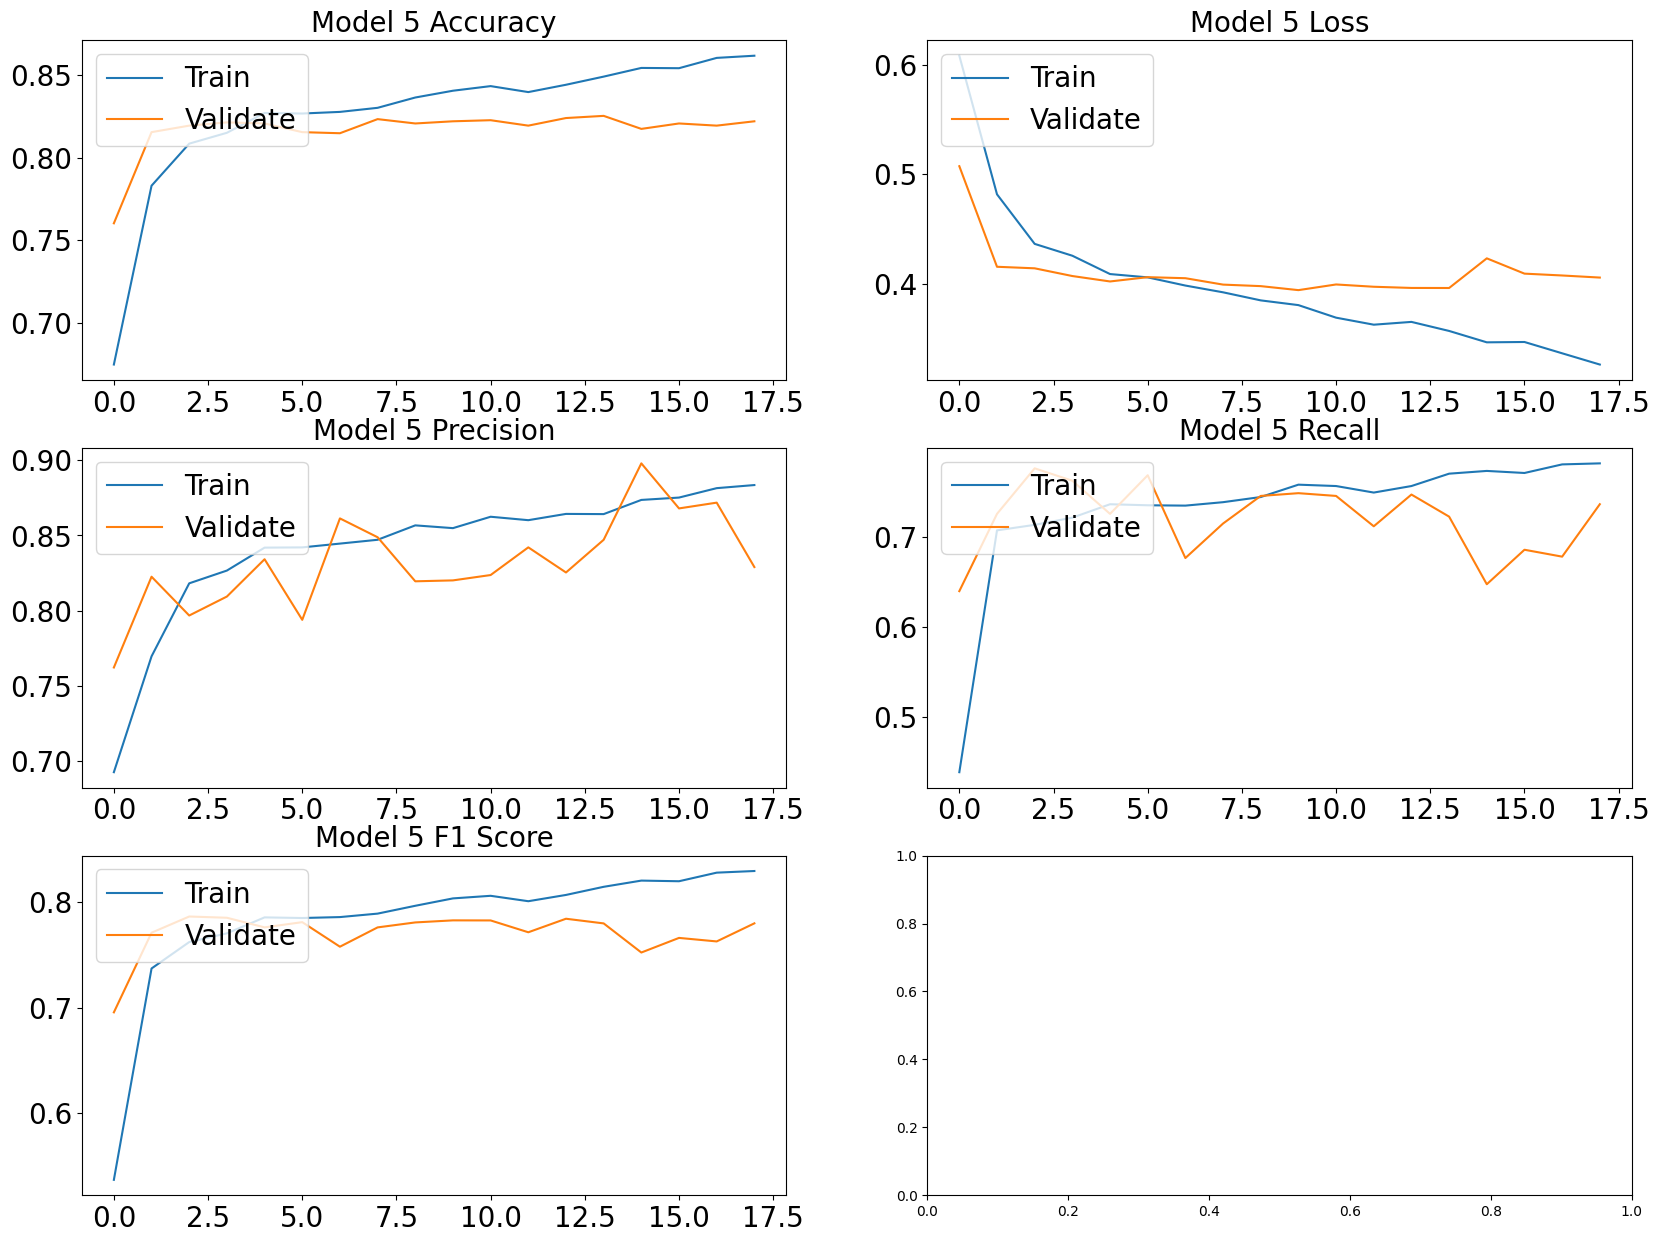

<Figure size 100x100 with 0 Axes>

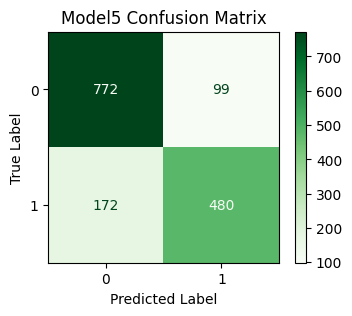

In [55]:
# Plot results
model5_val_accuracy, model5_val_precision, model5_val_recall ,model5_val_f1_scores = plot_results(history_model5, model_name='Model 5', early_stopping_callback=early_stopping_callback )
print("model 5 accuracy", model5_val_accuracy)
print("model 5 precision", model5_val_precision)
print("model 5 recall",model5_val_recall)
print("model 5 f1 score",   model5_val_f1_scores )

y_pred_model5=plot_cfm(model5, X=padded_val, y_actual= y_val, model_name='Model5')

In [56]:
# Take a look at wronly predicted tweets
# Get indices
fp_indices = np.where((np.array(y_pred_model5)== 1) & (y_val == 0))[0]
fn_indices = np.where((np.array(y_pred_model5)== 1) & (y_val == 1))[0]

# False positive
print('****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************')
indices = np.random.choice(fp_indices,10, replace=False)
for i in indices:
    print(X_val.iloc[i]['clean_text'] )
    
# False negative
print('****************************** Disaster tweets predicted as disaster tweets (False Negative) ***********************************')
indices = np.random.choice(fn_indices,10,replace=False)
for i in indices:
    print(X_val.iloc[i]['clean_text'] )

****************************** Non-disaster tweets predicted as disaster tweets (False Positive) ***********************************
Whimsy as it pertains to mass casualties .  Always impressive . 
 Articles In Saudi Press Reject Russian Initiative For Regional Alliance With Assad Regime To Fight Terrorism
Emergency Services Committee and Personnel Committee Meeting on Thursday Night 
I keep sneezing either someone placed a southern dust storm in my house or someone talkin smack
RT alisonannyoung :  EXCLUSIVE :  FedEx no longer to transport research specimens of bioterror pathogens in wake of anthrax lab mishaps Û_
 # CCOT  # TCOT  # radiation Nuclear Emergency Tracking Center


 @ songhey89 well I ' m also gay but girls like some too .  So .   I predict tsunami  & amp ;  volcano  & amp ;  earthquakes .  A gift from God ?  Am Christian but
her eyes and words are so icy but she burns like rum on the fire
 @ Georgous__ what alternatives ?  Legal alternatives ?  Protesting ?  Rioting may


### GRU Model with GloVe Performance  ⛈
 
- After serval attempts of tuning, the best GRU with GloVe F1 score is also around 0.75. 
- After just a few epochs, just like LSTM accuracy of both training and testing data is also around 0.85/0.82. So, just like LSTM, the model doesn't have much of overfitting or underfitting problems using similar hyper-parameters.
- For precision, recall, and confusion matrix, it's very similar to LSTM too (although on average runs, the precision and recall scores are closer than LSTM). I am not sure it's significant. That's expected becuase GRU is indeed similar to LSTM but sometimes better for smaller set of data. 



# <a id="20"></a>
<div style="text-align: center; background-color: #527506; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Part 5: Submit Test Results
🌅 </h1>

</div>

As discussed, GRU seems get 'evener' precision vs. recall scores. Thus, I will use GRU for final testing results.

In [57]:
# predict testing results
pred_prob = model5.predict(padded_test)
pred_prob = np.transpose(pred_prob)[0]
y_pred = list(map(lambda x: 0 if x < 0.5 else 1, pred_prob))

sample_submission["target"] = y_pred

102/102 [==============================] - 2s 22ms/step


In [58]:
sample_submission.to_csv("submission.csv", index=False)

The obtained F1 score on the testing data stands at 0.81, slightly surpassing our validation score of 0.79. This marginally higher performance on the testing set suggests that our model isn't overfitting. It's plausible that the difference in performance could be attributed to the smaller size of our validation set. Moreover, the predictability of the results may be intricately tied to the complexity of the tweet messages. Including more challenging tweets in our validation set could provide a more comprehensive evaluation of our model's performance.

# <a id="21"></a>
<div style="text-align: center; background-color: #527506; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Part 6: Conclusion
🌤
 </h1>

</div>

### Basic reiteration of result 
(For detailed explanations, please refer to discussions during each model training and tuning. Observations and reasoning behind the selection of certain models, tuning parameters, or methods are explained in detail.)
- Baseline model: Initially, a non-sequential model was employed, yielding an F1 score of approximately 0.75. However, this model exhibited significant overfitting issues.

- RNN with LSTM: To capture the sequential nature of the data, an RNN with LSTM architecture was utilized. Despite efforts to mitigate overfitting by employing a high dropout ratio of 0.8 and experimenting with larger batch sizes, the LSTM model failed to outperform the baseline. This could be attributed to the unique characteristics of tweet data, such as short sentences and the presence of slang, abbreviations, and typos.

- GloVe Word Embeddings: To address the word embedding problem, GloVe pre-trained embeddings were employed. This successfully alleviated the overfitting issue but introduced a new challenge of underfitting. By reducing the dropout rate and prolonging model training, the F1 score was improved to 0.79. However, concerns remained regarding recall and false negative rates.

- GRU Model: In an effort to further enhance the F1 score, particularly focusing on improving recall and reducing false negatives, a GRU model was explored. While the results were comparable to LSTM, there were instances where GRU exhibited slightly better recall and false negative rates, though the overall F1 score remained unchanged. Consequently, for the final results, the GRU model is preferred.
### Learnings and Take Aways:
Throughout this project, I've gleaned valuable insights into employing LSTM and GRU RNN models for predicting tweet message content. Here are some key takeaways:

- Corpus Cleaning Challenges: 
  - Traditional corpus cleaning techniques, such as removing stop words, punctuation, and stemming, commonly effective for larger and more formal corpus, may not yield optimal results for short, informal Twitter messages. The brevity and unique linguistic features of tweets pose distinct challenges. Less cleaning can preserve more important information.

- Benefits of Pre-trained Word Embeddings: 
  - In the realm of small and concise texts like tweets, leveraging pre-trained word embeddings like GloVe proves indispensable. These embeddings effectively bridge the gap between the divergent vocabulary of training and testing data, help with 'encoding' word meanings in small informal data set.

- Overfitting Challenges with LSTM: 
  - While LSTM models excel in handling sequential data, they are prone to severe overfitting when faced with substantial word embedding challenges. Despite exhaustive tuning efforts, including the use of high dropout rates, LSTM models often struggle to generalize well in these situations.

- Performance of LSTM and GRU with GloVe Embeddings:
  - Following the integration of GloVe embeddings to address word embedding discrepancies and data sparsity, both LSTM and GRU models demonstrate commendable performance with tweet data. Although both models exhibit comparable overall performance, GRU exhibits a slight edge in addressing imbalances between recall and precision.



### Future Improvements:
- Enhanced Corpus Cleaning: 
  - Further refinement of corpus cleaning methods could significantly enhance prediction accuracy for tweet texts. This includes more targeted cleaning strategies such as expanding informational usernames and hashtags, replacing character entity references with their corresponding symbols, removing special characters attached to words, expanding contractions, translating informal abbreviations into their full forms, correcting slang and typos, replacing words with their acronyms, and grouping related words. While these processes are time-consuming, they should greatly improve the quality of predictions.

- Exploration of Advanced Models: 
  - Consideration of alternative models such as Bidirectional Encoder Representations from Transformers (BERT) could be beneficial. BERT has demonstrated success across various natural language processing (NLP) tasks and generates vector-space representations of language suitable for deep learning models. Although not extensively explored in this project, BERT or similar models could be used for future enhancements.

# <a id="21"></a>

### Reference
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert <br>
https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets <br>
https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained <br>
https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove<br>
https://www.kaggle.com/code/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
